In [1]:
%matplotlib inline
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.dpi'] = 200
import matplotlib.colors as colors
import torch
import torch.nn as nn
import torch.optim as optim
import copy

In [2]:
# trial data
data = np.load('../data/andrew/sample_photostim_0113.npy', allow_pickle = True).item()
y = data['y']
u = data['u']
num_trials = y.shape[0]
num_steps = y.shape[1]
num_neurons = y.shape[2]
T_before = 4
T_after_start = 9
T_after_end = 13
y_before = np.mean(y[:,:T_before,:],axis = 1)
y_after = np.mean(y[:,T_after_start:T_after_end,:],axis = 1)

y_session = data['y_session']
u_session = data['u_session']

# linear interpolation of data
y_session_interp = y_session.copy()
for i in range(y_session.shape[1]):
    nan_start = -1
    nan_stop = -1
    for j in range(y_session.shape[0]):
        if nan_start == -1 and np.isnan(y_session_interp[j,i]):
            nan_start = j - 1
        if nan_start != -1 and not np.isnan(y_session_interp[j,i]):
            nan_stop = j
        if nan_start != -1 and nan_stop != -1:
            slope = y_session_interp[nan_stop,i] - y_session_interp[nan_start,i]
            for k in range(nan_stop - nan_start - 1):
                y_session_interp[nan_start + k + 1,i] = slope*k/(nan_stop-nan_start-1) + y_session_interp[nan_start,i]
            nan_start = -1
            nan_stop = -1
            
# y_session = y_session[4:,:]
# u_session = u_session[4:,:]
# y_session_interp = y_session_interp[4:,:]

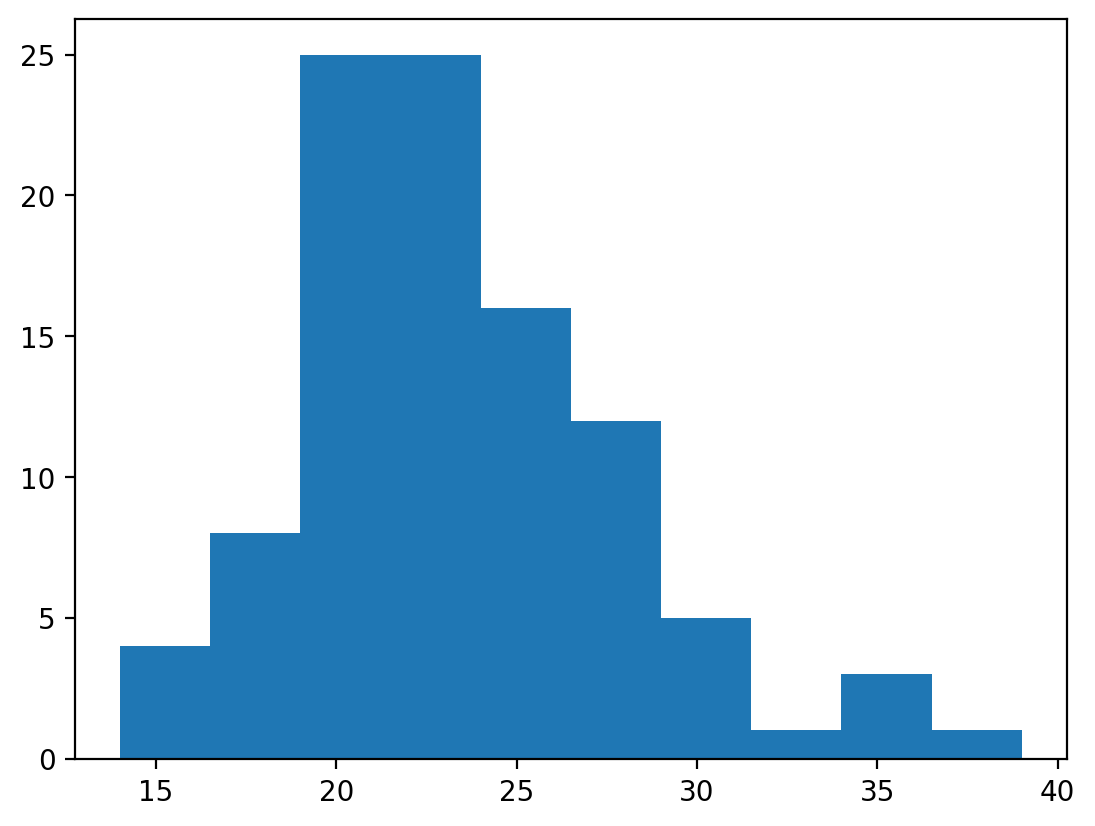

In [3]:
patterns = []
pattern_count = []
pattern_idx = []
pattern_length = []

start = -10
for t in range(u_session.shape[0]):
    if np.sum(np.abs(u_session[t,:])) > 0 and t > start + 4:
        idx = np.linspace(0,663-1,663).astype(int)
        on = u_session[t,:] > 0
        pattern = np.array(idx[on])
        start = t
        found = False
        for i in range(len(patterns)):
            if len(pattern) == len(patterns[i]):
                if np.linalg.norm(pattern - patterns[i]) == 0:
                    pattern_count[i] += 1
                    pattern_idx[i].append(t)
                    found = True
                    break
        if found is False:
            patterns.append(pattern)
            pattern_count.append(1)
            pattern_idx.append([t])
            pattern_length.append(len(pattern))

neuron_pattern = np.zeros(663)
for i in range(663):
    for p in patterns:
        if i in p:
            neuron_pattern[i] += 1

plt.hist(pattern_count)
plt.show()

In [4]:
# remove patterns by neuron

'''
num_neurons = 5
removed_patterns = []
excluded_patterns = []
removed_neurons = []
removed_steps = np.zeros(u_session.shape[0])
removed_count = 0

while len(removed_neurons) < num_neurons:
    neuron = np.random.randint(0,663)
    if neuron not in removed_neurons and neuron_pattern[neuron] > 1:
        removed_neurons.append(neuron)
        removed = False
        for p_idx in range(len(patterns)):
            if neuron in patterns[p_idx] and p_idx not in removed_patterns and p_idx not in excluded_patterns and removed is False:
                removed_patterns.append(p_idx)
                removed_count += pattern_count[p_idx]
                for i in pattern_idx[p_idx]:
                    min_idx = np.max([0,i-20])
                    max_idx = np.min([i+50,u_session.shape[0]-1])
                    removed_steps[min_idx:max_idx] = 1
                removed = True
            if neuron in patterns[p_idx] and p_idx not in removed_patterns and p_idx not in excluded_patterns and removed is True:
                excluded_patterns.append(p_idx)
            
                
print(removed_count, np.sum(removed_steps) / u_session.shape[0])
print(len(removed_patterns))
plt.figure(figsize=(20,5))
plt.plot(removed_steps)
plt.show()

test_indices = removed_steps.astype(int)
train_indices = np.ones(test_indices.shape[0]).astype(int) - test_indices.copy()
'''

'\nnum_neurons = 5\nremoved_patterns = []\nexcluded_patterns = []\nremoved_neurons = []\nremoved_steps = np.zeros(u_session.shape[0])\nremoved_count = 0\n\nwhile len(removed_neurons) < num_neurons:\n    neuron = np.random.randint(0,663)\n    if neuron not in removed_neurons and neuron_pattern[neuron] > 1:\n        removed_neurons.append(neuron)\n        removed = False\n        for p_idx in range(len(patterns)):\n            if neuron in patterns[p_idx] and p_idx not in removed_patterns and p_idx not in excluded_patterns and removed is False:\n                removed_patterns.append(p_idx)\n                removed_count += pattern_count[p_idx]\n                for i in pattern_idx[p_idx]:\n                    min_idx = np.max([0,i-20])\n                    max_idx = np.min([i+50,u_session.shape[0]-1])\n                    removed_steps[min_idx:max_idx] = 1\n                removed = True\n            if neuron in patterns[p_idx] and p_idx not in removed_patterns and p_idx not in exclud

pattern id: 44
pattern id: 47
pattern id: 64
pattern id: 67
pattern id: 67
pattern id: 9
113 0.21980532969315686
5


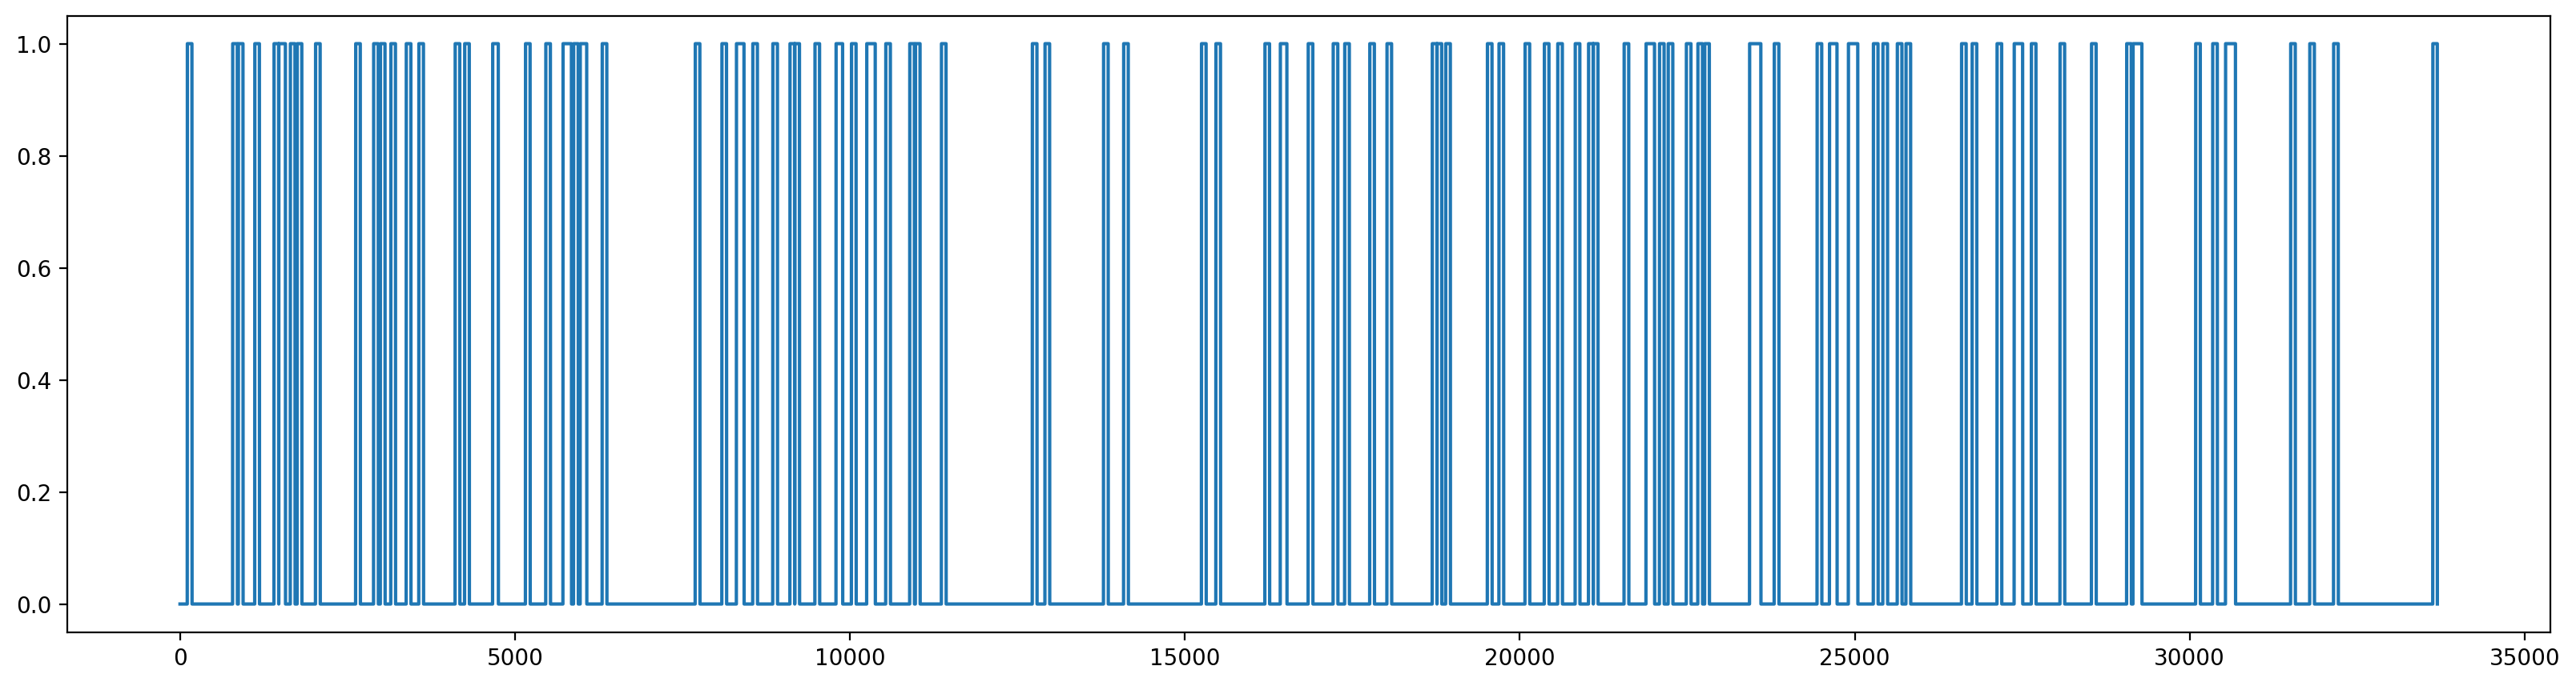

In [4]:
# remove patterns randomly

num_patterns = 5
removed_patterns = []
removed_neurons = []
removed_steps = np.zeros(u_session.shape[0])
removed_count = 0

np.random.seed(0)
while len(removed_patterns) < num_patterns:
    p_idx = np.random.randint(0,len(patterns))
    print('pattern id:', p_idx)
    if p_idx not in removed_patterns:
        removed_patterns.append(p_idx)
        removed_count += pattern_count[p_idx]
        removed_neurons.extend(patterns[p_idx])
        for i in pattern_idx[p_idx]:
            min_idx = np.max([0,i-20])
            max_idx = np.min([i+50,u_session.shape[0]-1])
            removed_steps[min_idx:max_idx] = 1
            
                
print(removed_count, np.sum(removed_steps) / u_session.shape[0])
print(len(removed_patterns))
plt.figure(figsize=(20,5))
plt.plot(removed_steps)
plt.show()

test_indices = removed_steps.astype(int)
train_indices = np.ones(test_indices.shape[0]).astype(int) - test_indices.copy()
removed_neurons = list(set(removed_neurons))

train_test_split = {}
train_test_split['train_indices'] = train_indices
train_test_split['test_indices'] = test_indices
# np.save('train_test_split',train_test_split)

In [5]:
spiking = np.zeros(u_session.shape).astype(bool)

for neuron in range(u_session.shape[1]):
    output_true = y_session_interp[4:,neuron]
    mean_threshold = np.median(output_true)
    lower_tail_idx = (output_true < mean_threshold)
    lower_tail_data = output_true[lower_tail_idx]
    lower_tail_std = np.std(lower_tail_data)
    print(lower_tail_std)
    true_spike_threshold = mean_threshold + 6*lower_tail_std
    true_spikes = (output_true > true_spike_threshold)
    spiking[4:,neuron] = true_spikes  
    
#np.save('spiking_labels',spiking)

10.926305
6.8637924
10.2582035
8.80526
9.282541
10.277796
19.47125
8.010129
6.368451
12.515049
8.127925
7.872719
9.254664
9.460864
6.900674
6.7014256
13.435938
13.280504
5.815727
5.553677
7.1259336
7.792279
13.807764
8.649218
10.296269
10.225375
10.375469
13.5954075
10.399429
7.4910517
6.2267127
6.7933927
9.528945
6.36728
10.152898
5.5899534
11.161926
8.639719
4.9650493
6.7699227
7.3379025
9.040896
7.3271065
11.73246
13.986362
9.226959
8.180463
5.7991967
9.400248
13.124448
11.497623
5.844215
10.059646
9.304157
9.6105795
5.063303
7.6047525
6.7856374
7.1048026
10.863687
8.672426
12.873427
5.566862
9.275431
11.061833
6.51319
8.993106
5.0163984
5.834947
9.683207
7.2687974
11.5129175
11.0101385
9.233922
10.026835
11.600518
9.963518
11.38672
7.4664526
10.166133
9.710266
9.179704
15.667917
5.734885
7.3031383
8.293233
14.334215
7.272676
8.916961
10.608227
11.324754
11.225982
7.0736065
10.678194
11.547289
9.894718
8.6037245
10.13237
7.8902493
13.090778
5.7624125
13.112546
8.051336
8.795618
8.71

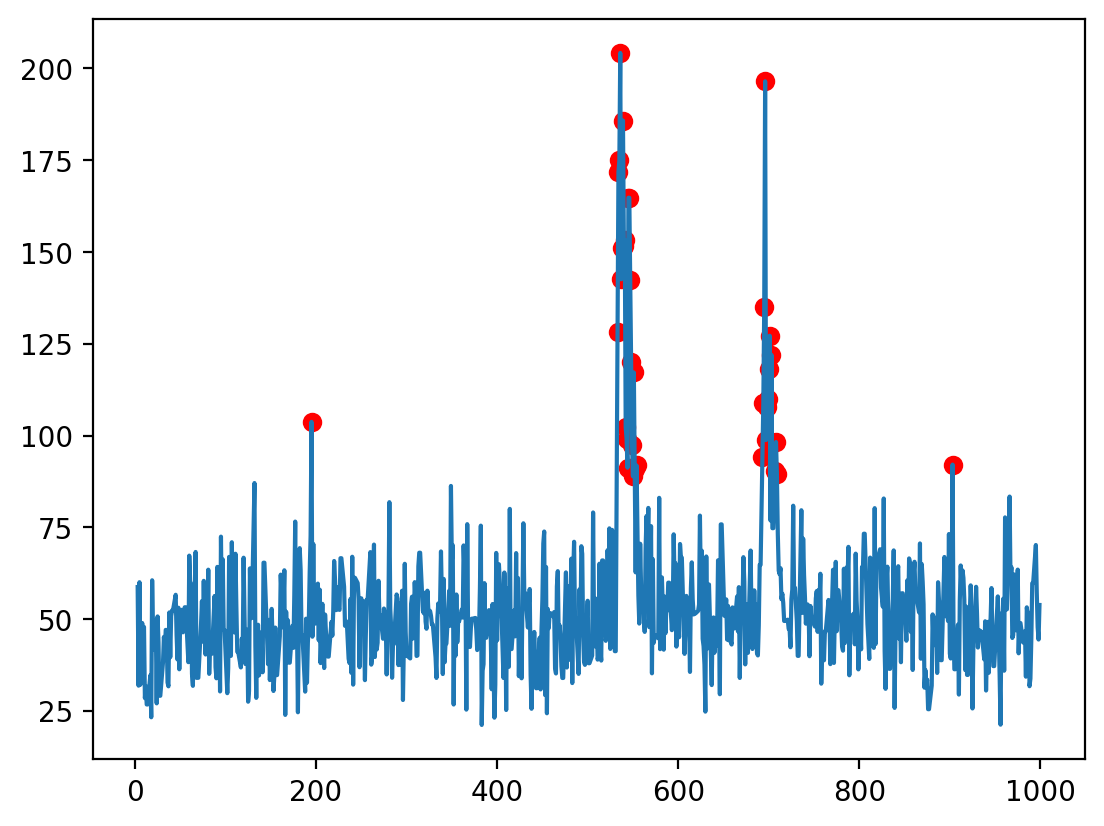

In [6]:
neuron = 206
T = 1000
plt.plot(y_session_interp[:T,neuron])
idx = np.linspace(0,T-1,T)
spiking_neuron = spiking[:T,neuron]
y_out = y_session_interp[0:T,neuron].copy()
y_out = y_out * spiking_neuron
y_out[y_out == 0] = np.nan
plt.scatter(idx,y_out,color='r')  
plt.show()

# Train Model

In [7]:
normalize = 1000
'''
y_session_interp_mean = np.nanmean(y_session_interp, axis = 0)
y_session_interp_std = np.nanmean(y_session_interp, axis = 0)
y_session_interp = (y_session_interp - y_session_interp_mean[np.newaxis, :])/y_session_interp_std[np.newaxis, :]
'''

'\ny_session_interp_mean = np.nanmean(y_session_interp, axis = 0)\ny_session_interp_std = np.nanmean(y_session_interp, axis = 0)\ny_session_interp = (y_session_interp - y_session_interp_mean[np.newaxis, :])/y_session_interp_std[np.newaxis, :]\n'

In [8]:
time_window = 16
F_train = []
input_train = []
input_id_train = []
for t in range(train_indices.shape[0]-time_window):
    if np.sum(train_indices[t:t+time_window+1]) == time_window + 1 and t > 5 + time_window:
        F_train.append(y_session_interp[t:t+time_window,:])
        input_id_train.append(u_session[t:t+time_window,:])
        input_train.append(
            np.repeat(np.expand_dims(
            np.max(u_session[t:t+time_window,:], axis = 1), axis = 1), 
            u_session[t:t+time_window,:].shape[1], axis = 1))
        
F_valid = []
input_valid = []
input_id_valid = []
for t in range(test_indices.shape[0]-time_window):
    if np.sum(test_indices[t:t+time_window+1]) == time_window + 1:
        F_valid.append(y_session_interp[t:t+time_window,:])
        input_id_valid.append(u_session[t:t+time_window,:])
        input_valid.append(
            np.repeat(np.expand_dims(
            np.max(u_session[t:t+time_window,:], axis = 1), axis = 1), 
            u_session[t:t+time_window,:].shape[1], axis = 1))

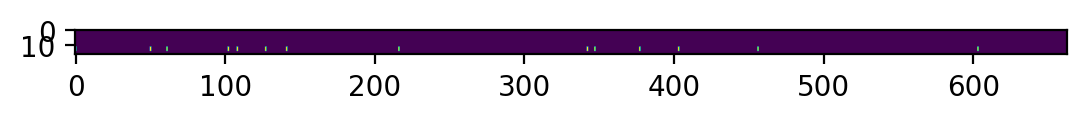

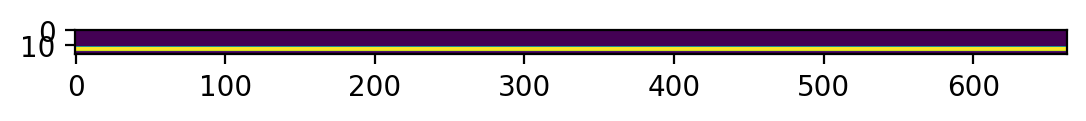

In [9]:
train_data_id = 80
plt.figure()
plt.imshow(input_id_train[train_data_id])
plt.figure()
plt.imshow(input_train[train_data_id])

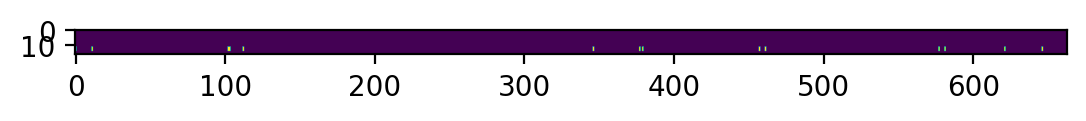

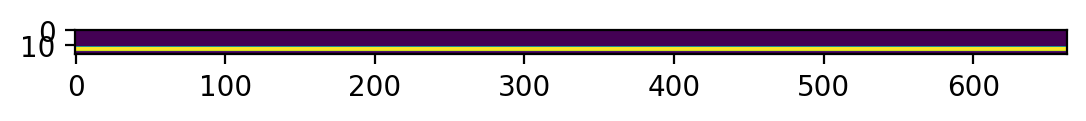

In [10]:
valid_data_id = 1000
plt.figure()
plt.imshow(input_id_valid[valid_data_id])
plt.figure()
plt.imshow(input_valid[valid_data_id])

In [11]:
# load model
import sys
sys.path.append("../") # go to parent dir
from lfads_fluo_simple_prediction_stim_input_mask_init import LFADS_Net
from utils import read_data, load_parameters, save_parameters, batchify_random_sample

In [12]:
print(y.shape[0], y.shape[1], y.shape[2])

2308 16 663


In [100]:
# model_name_1 = 'photostim_motor_andrew_data_g_window_size_16_mse_1024_0325/'
# model_name_1 = 'photostim_motor_andrew_data_g_1024_window_size_16_kl_start_1000000_mse_1024_0325/'
model_name_1 = 'photostim_motor_andrew_data_g_512_window_size_16_mse_1024_0325/'
load_path_1 = '../models/optogenetic_motor_data_shuffle_prediction_photostim_stim_input_simple_model/' + model_name_1
hyperparams_1 = load_parameters(load_path_1+'parameters.yaml')
save_parameters(hyperparams_1)

T_init = 4
device = 'cuda'
model = LFADS_Net(inputs_dim = y.shape[2], 
                    T = y.shape[1], 
                    T_init = T_init, 
                    dt = 0.05, 
                    device = device,
                    model_hyperparams=hyperparams_1).to(device)
model.load_checkpoint('best', output = '')

Random seed: 9118
neuron
loss_form: MSE
save_loc: ../models/optogenetic_motor_data_shuffle_prediction_photostim_stim_input_simple_model/photostim_motor_andrew_data_g_512_window_size_16_mse_1024_0325/checkpoints/
Load checkpoint: ../models/optogenetic_motor_data_shuffle_prediction_photostim_stim_input_simple_model/photostim_motor_andrew_data_g_512_window_size_16_mse_1024_0325/checkpoints/best.pth


In [44]:
def to_np(tens):
    return tens.detach().cpu().numpy()

In [119]:
from torch.autograd import Variable

x_pred = []
x_pred_logvar = []
x_true = []
u_true = []
idx = -1

new_segment = True
segment_pred = []
segment_start = -1

model.eval()
prev_save = model.save_variables
batch_size = 1

with torch.no_grad():
    for t in range(train_indices.shape[0]):
        if test_indices[t] == 1:
            if new_segment:
                segment_pred = []
                new_segment = False
                segment_start = t
                x_past = []
                x_pred.append([])
                x_pred_logvar.append([])
                x_true.append([])
                u_true.append([])
                idx += 1
            if t < segment_start + T_init:
                x_past.append(y_session_interp[t,:]/normalize)
                past_steps = torch.Tensor(np.array(x_past)).unsqueeze(0).to(device)
                if t == segment_start + T_init - 1:
                    efgen = Variable(torch.zeros((batch_size, model.g0_encoder_dim)).to(device))  # Forward generator encoder
                    ebgen = Variable(torch.zeros((batch_size, model.g0_encoder_dim)).to(device))  # Backward generator encoder
                    # Encode data into forward and backward generator encoders to produce E_gen
                    # for generator initial conditions.
                    for t in range(1, model.T_init + 1):
                        efgen = torch.clamp(model.gru_Egen_forward(past_steps[:, t - 1, :], efgen), max = model.clip_val)
                        ebgen = torch.clamp(model.gru_Egen_backward(past_steps[:, model.T_init - t, :], ebgen), max = model.clip_val)
                    # Concatenate efgen_T and ebgen_1 for generator initial condition sampling
                    egen = torch.cat((efgen, ebgen), dim=1)
                    # Infer initial conditions for generator from g0 posterior distribution
                    g = model.fc_g0mean(egen)
            else:
                # Update generator
                u_input = torch.Tensor(u_session[t,:]).unsqueeze(0).to(device)
                g = torch.clamp(model.gru_generator(u_input, g), min = 0.0, max = model.clip_val)
                # Generate output Gaussain mu from generator state
                mu = model.fc_mu(g)
                # Generate output Gaussain logvar from generator state
                logvar = model.fc_logvar(g)
                x_pred[idx].append(to_np(mu[0]))
                x_pred_logvar[idx].append(to_np(logvar[0]))
                x_true[idx].append(y_session_interp[t,:]/normalize)
                u_true[idx].append(u_session[t,:])
        else:
            new_segment = True

mse_losses = []
for i in range(len(x_pred)):
    x_pred[i] = np.array(x_pred[i])
    x_true[i] = np.array(x_true[i])
    u_true[i] = np.array(u_true[i])
    mse_losses.append((np.square(x_pred[i] - x_true[i])).mean())
print('mse:', sum(mse_losses)/len(mse_losses))

mse: 0.0007852678560945941


Text(0.5, 1.0, 'kld v.s. epoch')

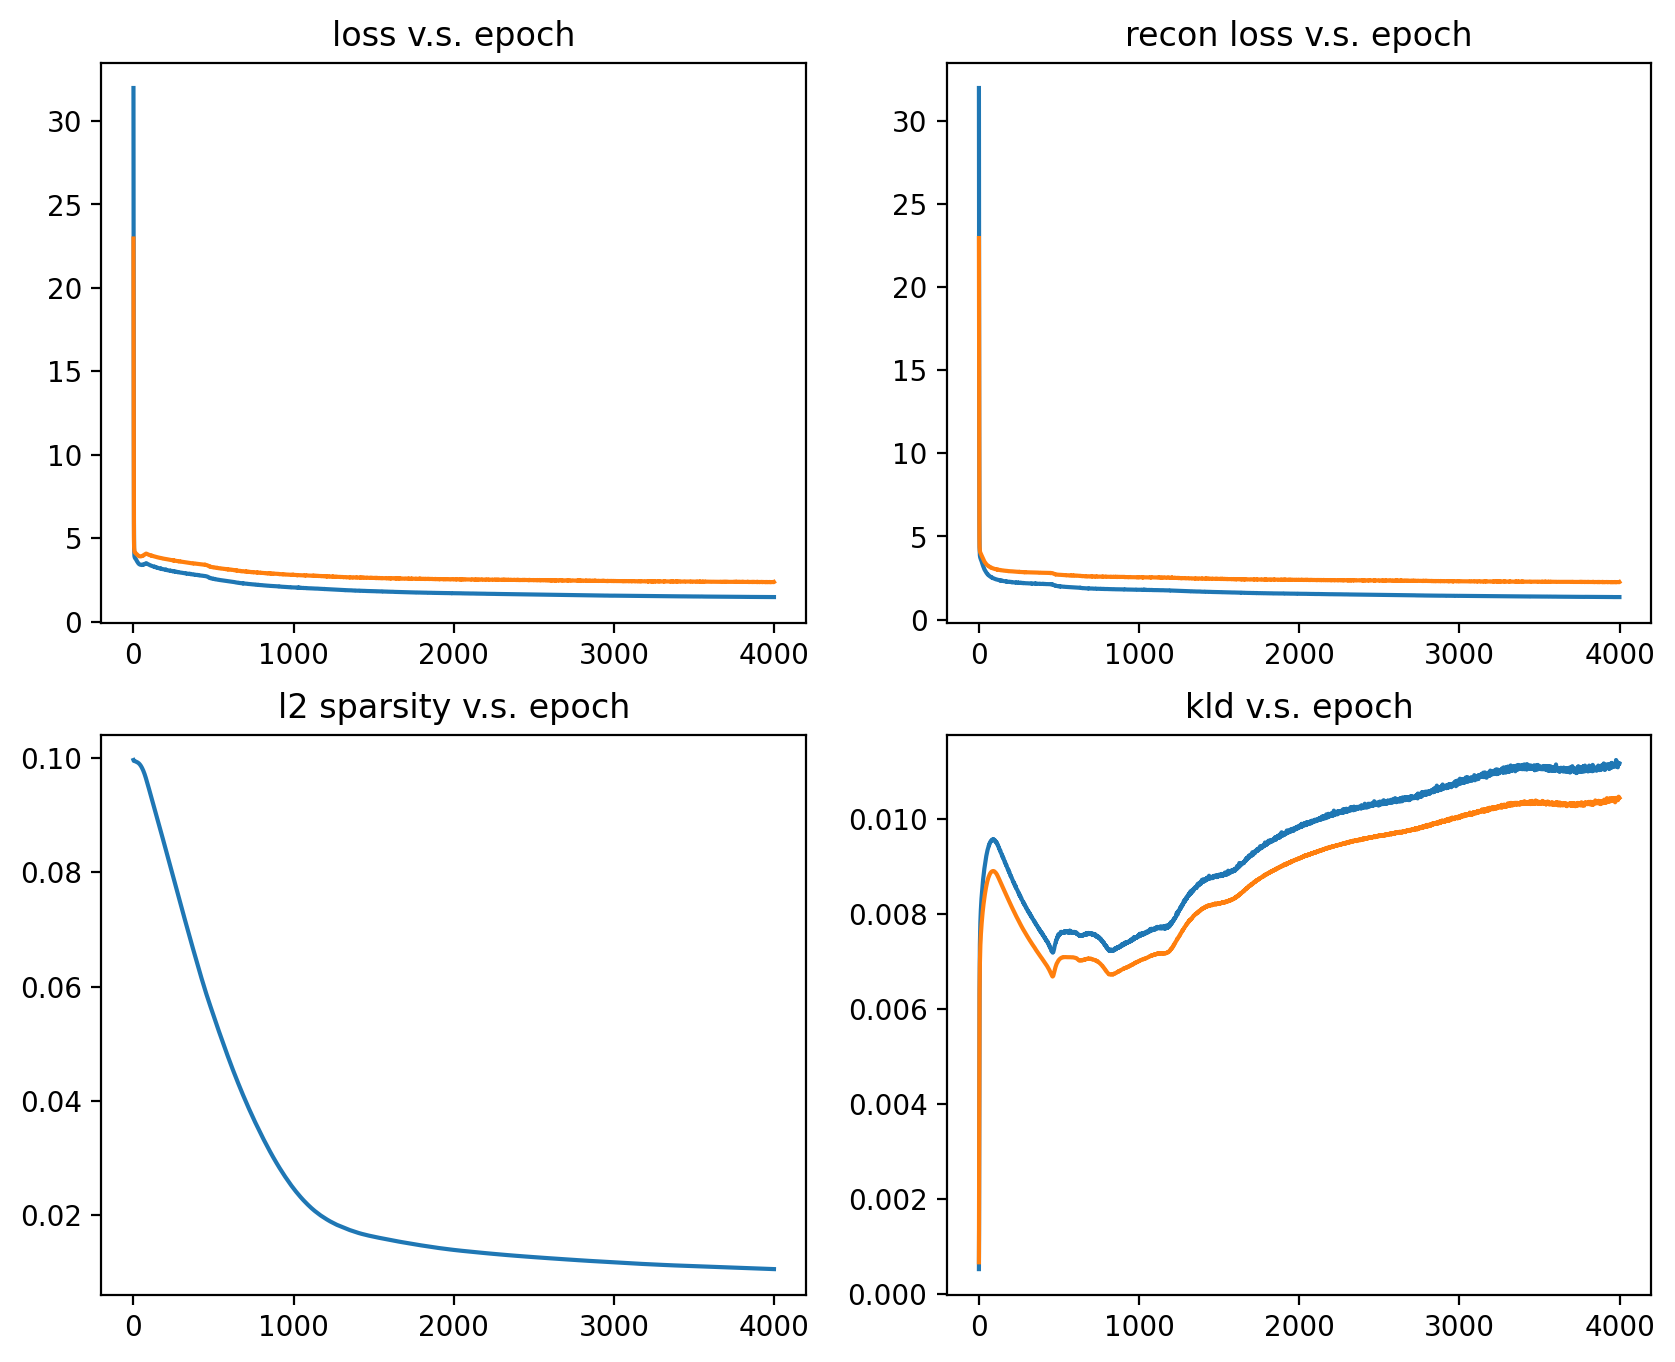

In [102]:
import csv
fig, axs = plt.subplots(2, 2, figsize = (10, 8))

epochs = []
train_losses = []
train_recon_losses = []
train_kld = []
train_l2 = []
valid_losses = []
valid_recon_losses = []
valid_kld = []
clip_max = 1500

with open(load_path_1+'loss.csv', newline='') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        epochs.append(int(row['epoch']))
        train_losses.append(np.clip(float(row['train_loss']), a_min = 0, a_max = clip_max))
        train_recon_losses.append(np.clip(float(row['train_recon_loss']), a_min = 0, a_max = clip_max))
        train_kld.append(float(row['train_kl_loss']))
        train_l2.append(float(row['l2_loss']))
        valid_losses.append(np.clip(float(row['valid_loss']), a_min = 0, a_max = clip_max))
        valid_recon_losses.append(np.clip(float(row['valid_recon_loss']), a_min = 0, a_max = clip_max))
        valid_kld.append(float(row['valid_kl_loss']))

axs[0,0].plot(np.asarray(epochs), np.asarray(train_losses))
axs[0,0].plot(np.asarray(epochs), np.asarray(valid_losses))
axs[0,0].set_title('loss v.s. epoch')

axs[0,1].plot(np.asarray(epochs), np.asarray(train_recon_losses))
axs[0,1].plot(np.asarray(epochs), np.asarray(valid_recon_losses))
axs[0,1].set_title('recon loss v.s. epoch')

axs[1,0].plot(np.asarray(epochs), np.asarray(train_l2))
axs[1,0].set_title('l2 sparsity v.s. epoch')

axs[1,1].plot(np.asarray(epochs), np.asarray(train_kld))
axs[1,1].plot(np.asarray(epochs), np.asarray(valid_kld))
axs[1,1].set_title('kld v.s. epoch')

In [81]:
# linear model
ark_order = 4
X = []
Xp = []
for t in range(train_indices.shape[0]-ark_order):
    if np.sum(train_indices[t:t+ark_order+1]) == ark_order + 1 and t > 5 + ark_order:
        X.append(np.concatenate((y_session_interp[t:t+ark_order,:].copy().flatten()/normalize, u_session[t:t+ark_order,:].copy().flatten(),np.ones(1)))) 
        Xp.append(y_session_interp[t+ark_order,:].copy().flatten()/normalize)
X = np.array(X)
Xp = np.array(Xp)
Ahat = np.linalg.pinv(X.T @ X) @ X.T @ Xp
Ahat = Ahat.T

In [120]:
# linear model
x_pred = []
x_true = []
u_true = []
idx = -1
ark_order = 4
new_segment = True
segment_pred = []
segment_start = -1
for t in range(train_indices.shape[0]):
    if test_indices[t] == 1:
        if new_segment:
            segment_pred = []
            new_segment = False
            segment_start = t
            x_past = []
            x_pred.append([])
            x_true.append([])
            u_true.append([])
            idx += 1
        if t < segment_start + ark_order:
            x_past.append(y_session_interp[t,:].copy().flatten()/normalize)
        else:
            z = np.array(x_past).flatten()
            z = np.concatenate((z,u_session[t-ark_order:t,:].copy().flatten(),np.ones(1)))
            x_next = Ahat @ z
            x_past.pop(0)
            x_past.append(x_next.copy())
            x_pred[idx].append(x_next.copy())
            x_true[idx].append(y_session_interp[t,:].copy().flatten()/normalize)
            u_true[idx].append(u_session[t,:].copy().flatten())
    else:
        new_segment = True

mse_losses = []
for i in range(len(x_pred)):
    x_pred[i] = np.array(x_pred[i])
    x_true[i] = np.array(x_true[i])
    u_true[i] = np.array(u_true[i])
    mse_losses.append((np.square(x_pred[i] - x_true[i])).mean())
    r2.append(r2_score(x_true[i], x_pred[i]))
print('mse:', sum(mse_losses)/len(mse_losses))

mse: 0.0005586116027758869


Text(0.5, 1.0, 'Input')

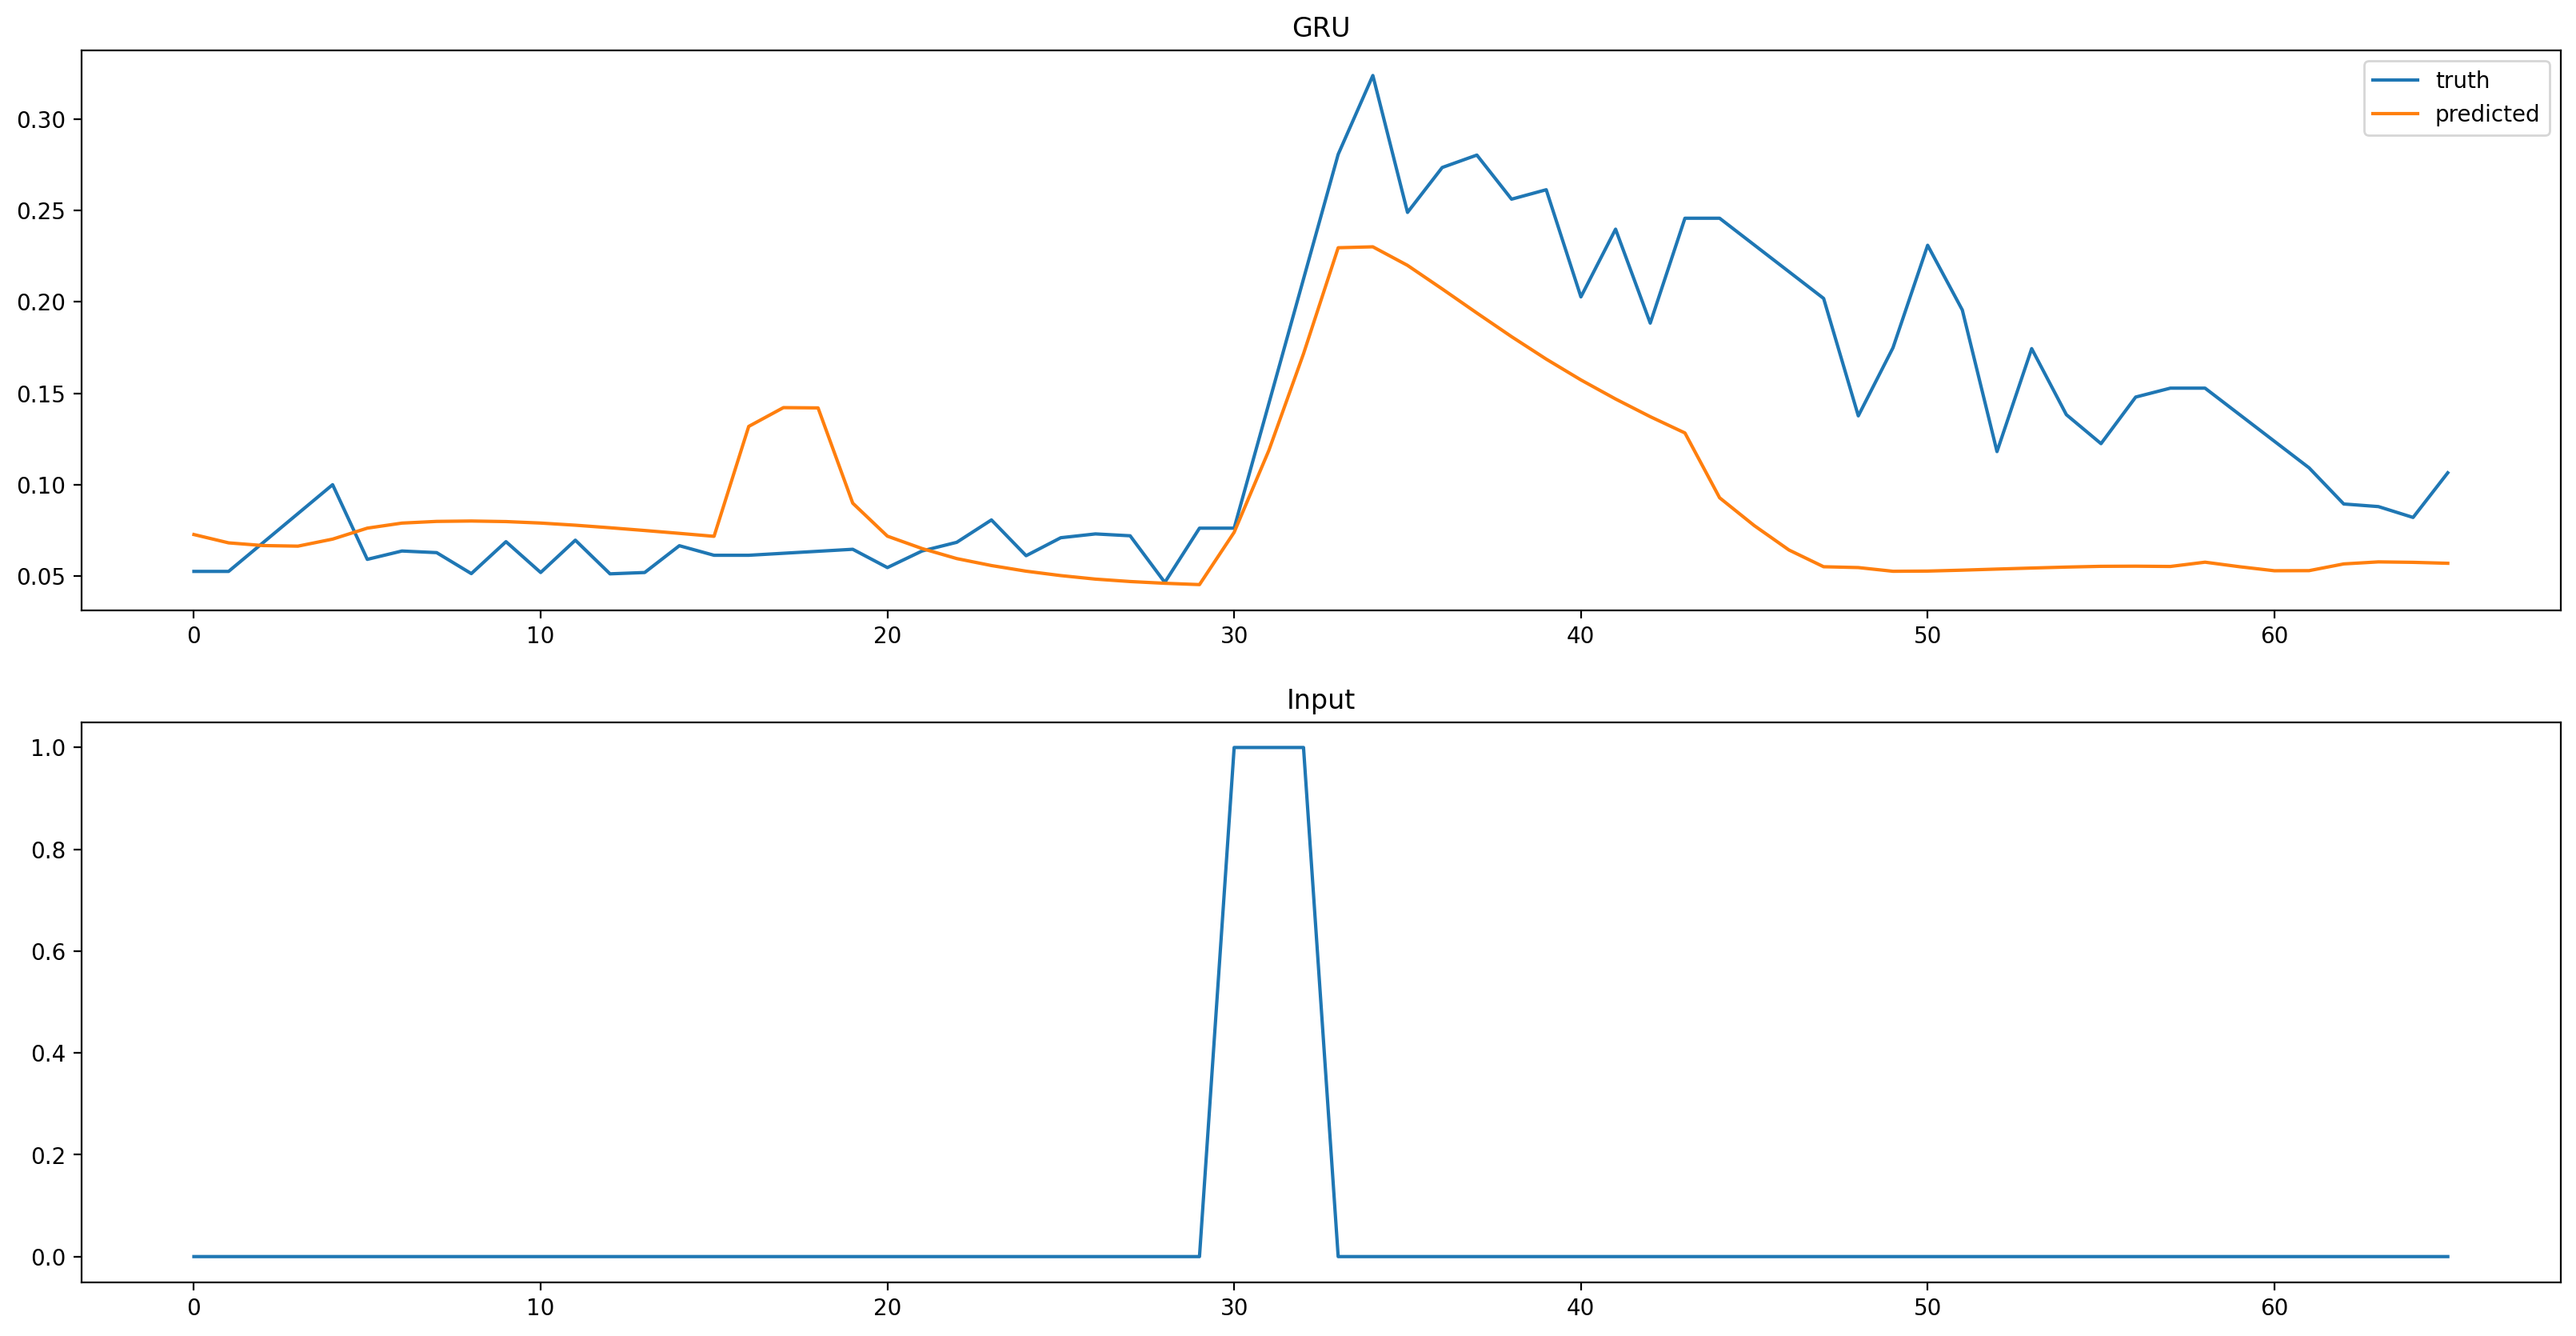

In [103]:
# deep model + test + mse
neuron = 1
idx = 0

plt.figure(figsize=(20,10))
plt.subplot(2,1,1)
plt.plot(x_true[idx][:,neuron],label='truth')
plt.plot(x_pred[idx][:,neuron],label='predicted')
plt.title('GRU')
plt.legend()

plt.subplot(2,1,2)
plt.plot(u_true[idx][:,neuron],label='input')
plt.title('Input')

Text(0.5, 1.0, 'Input')

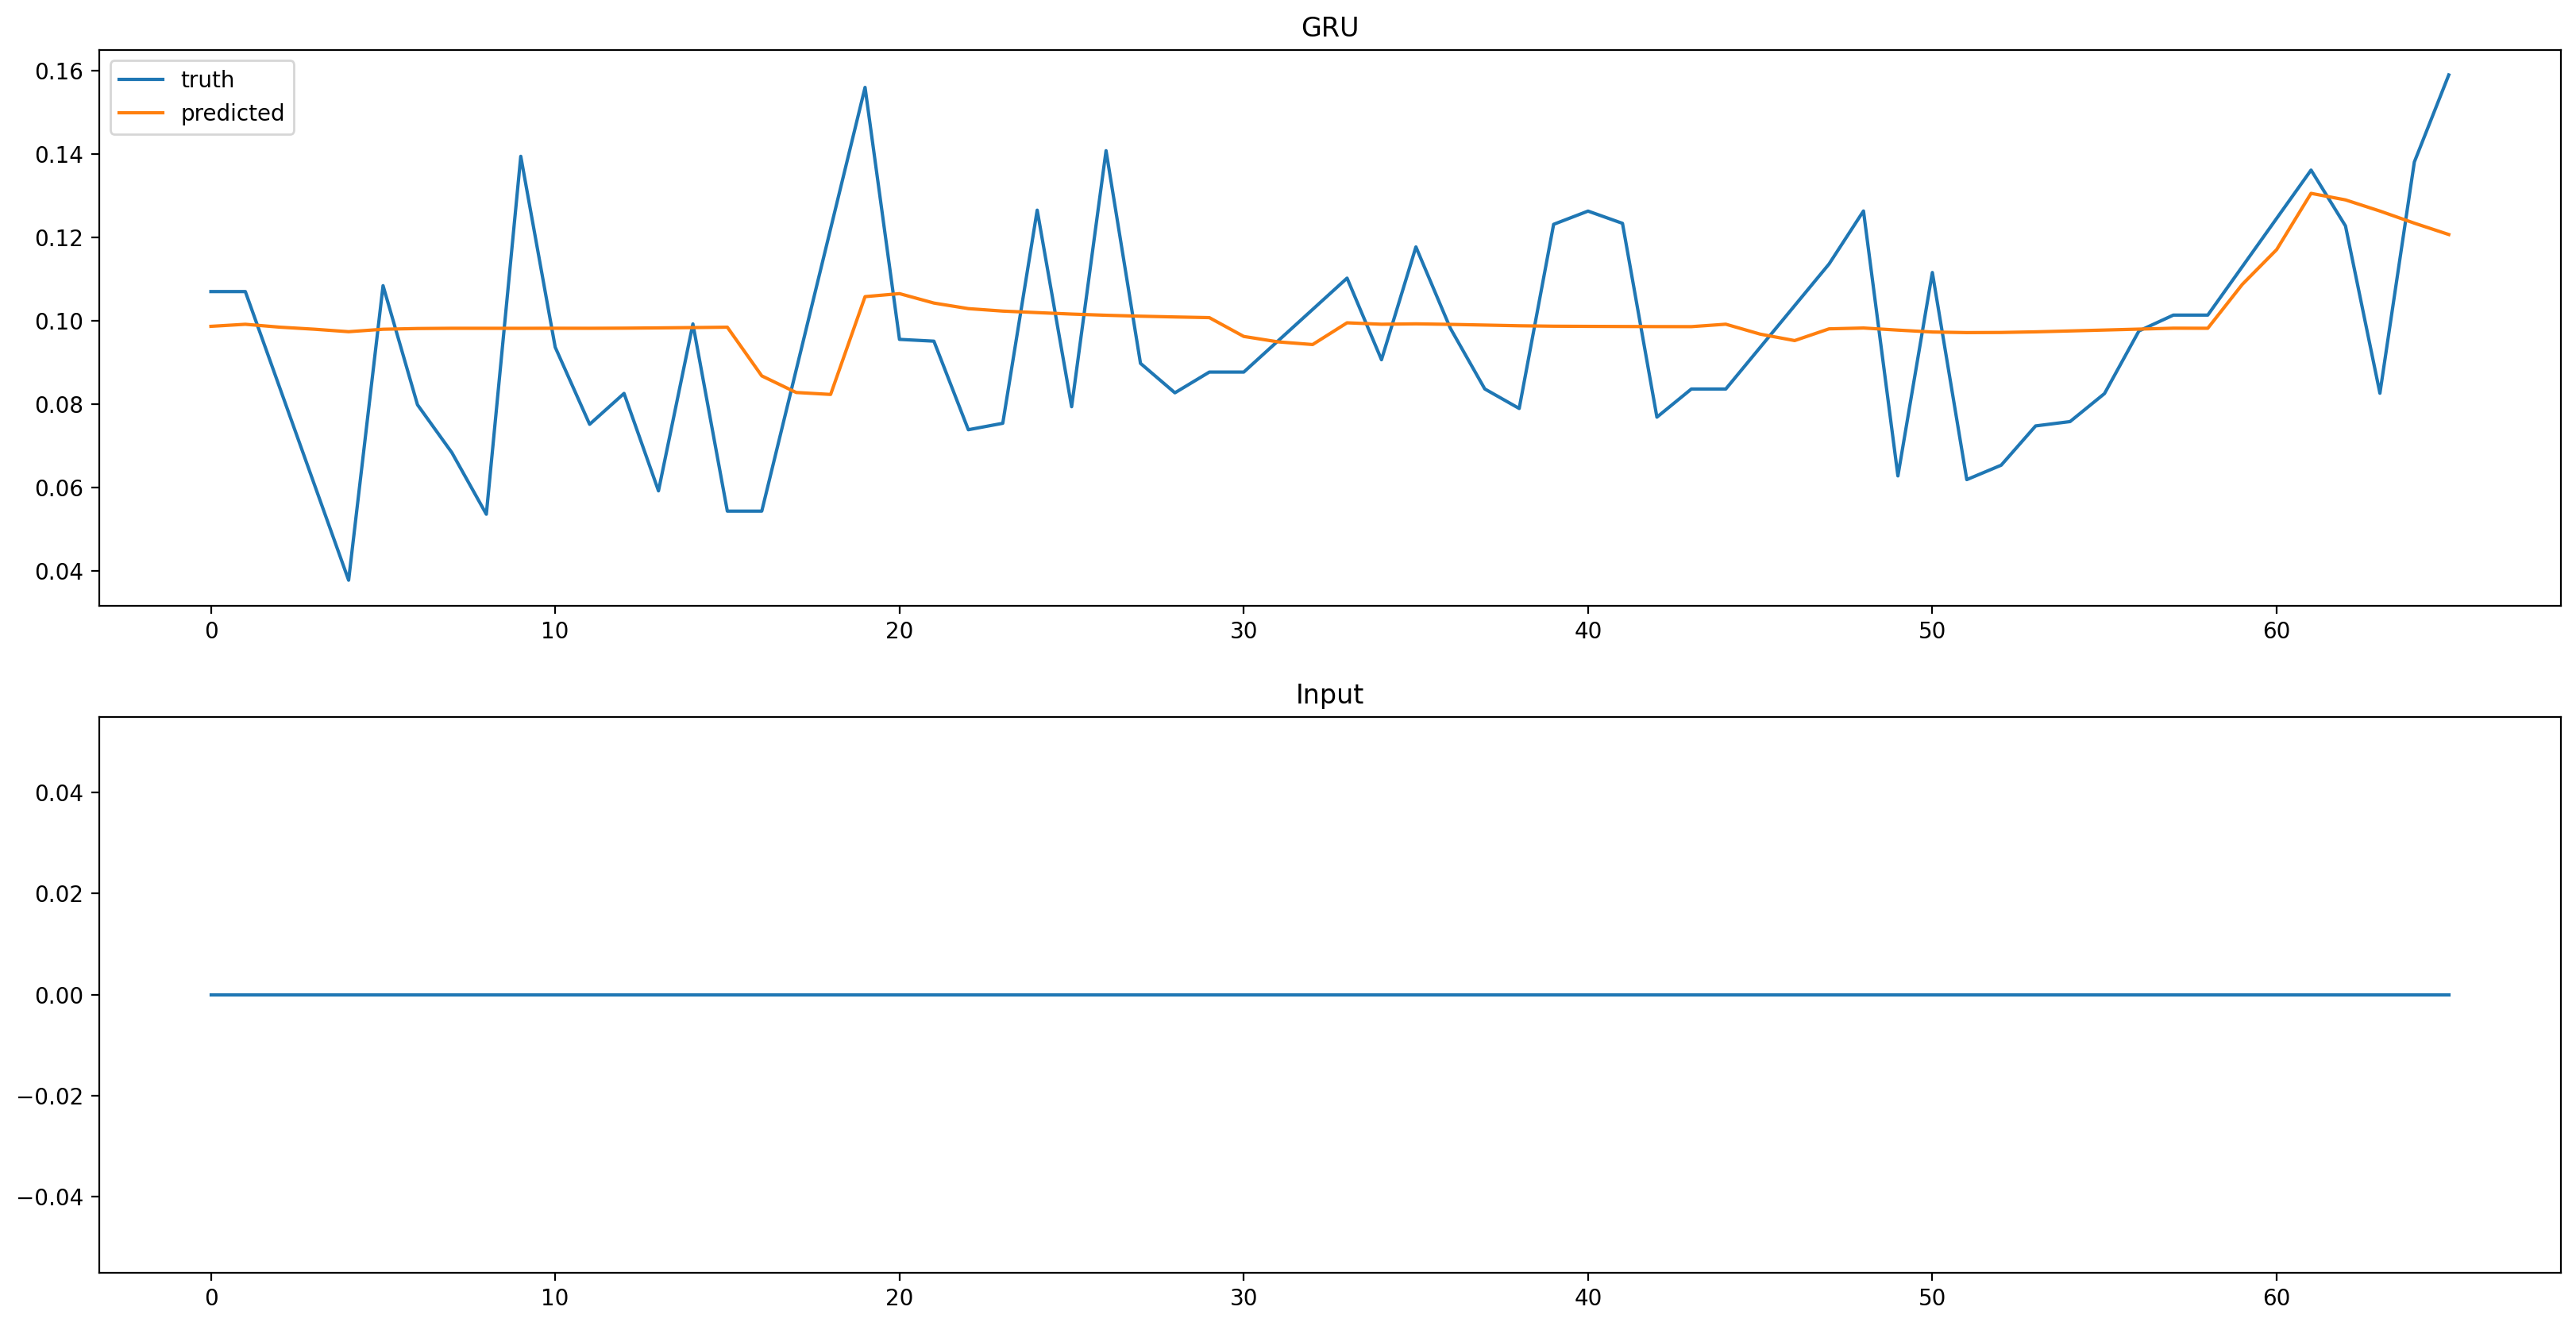

In [104]:
# deep model + test
neuron = 27
idx = 0

plt.figure(figsize=(20,10))
plt.subplot(2,1,1)
plt.plot(x_true[idx][:,neuron],label='truth')
plt.plot(x_pred[idx][:,neuron],label='predicted')
plt.title('GRU')
plt.legend()

plt.subplot(2,1,2)
plt.plot(u_true[idx][:,neuron],label='input')
plt.title('Input')

Text(0.5, 1.0, 'Input')

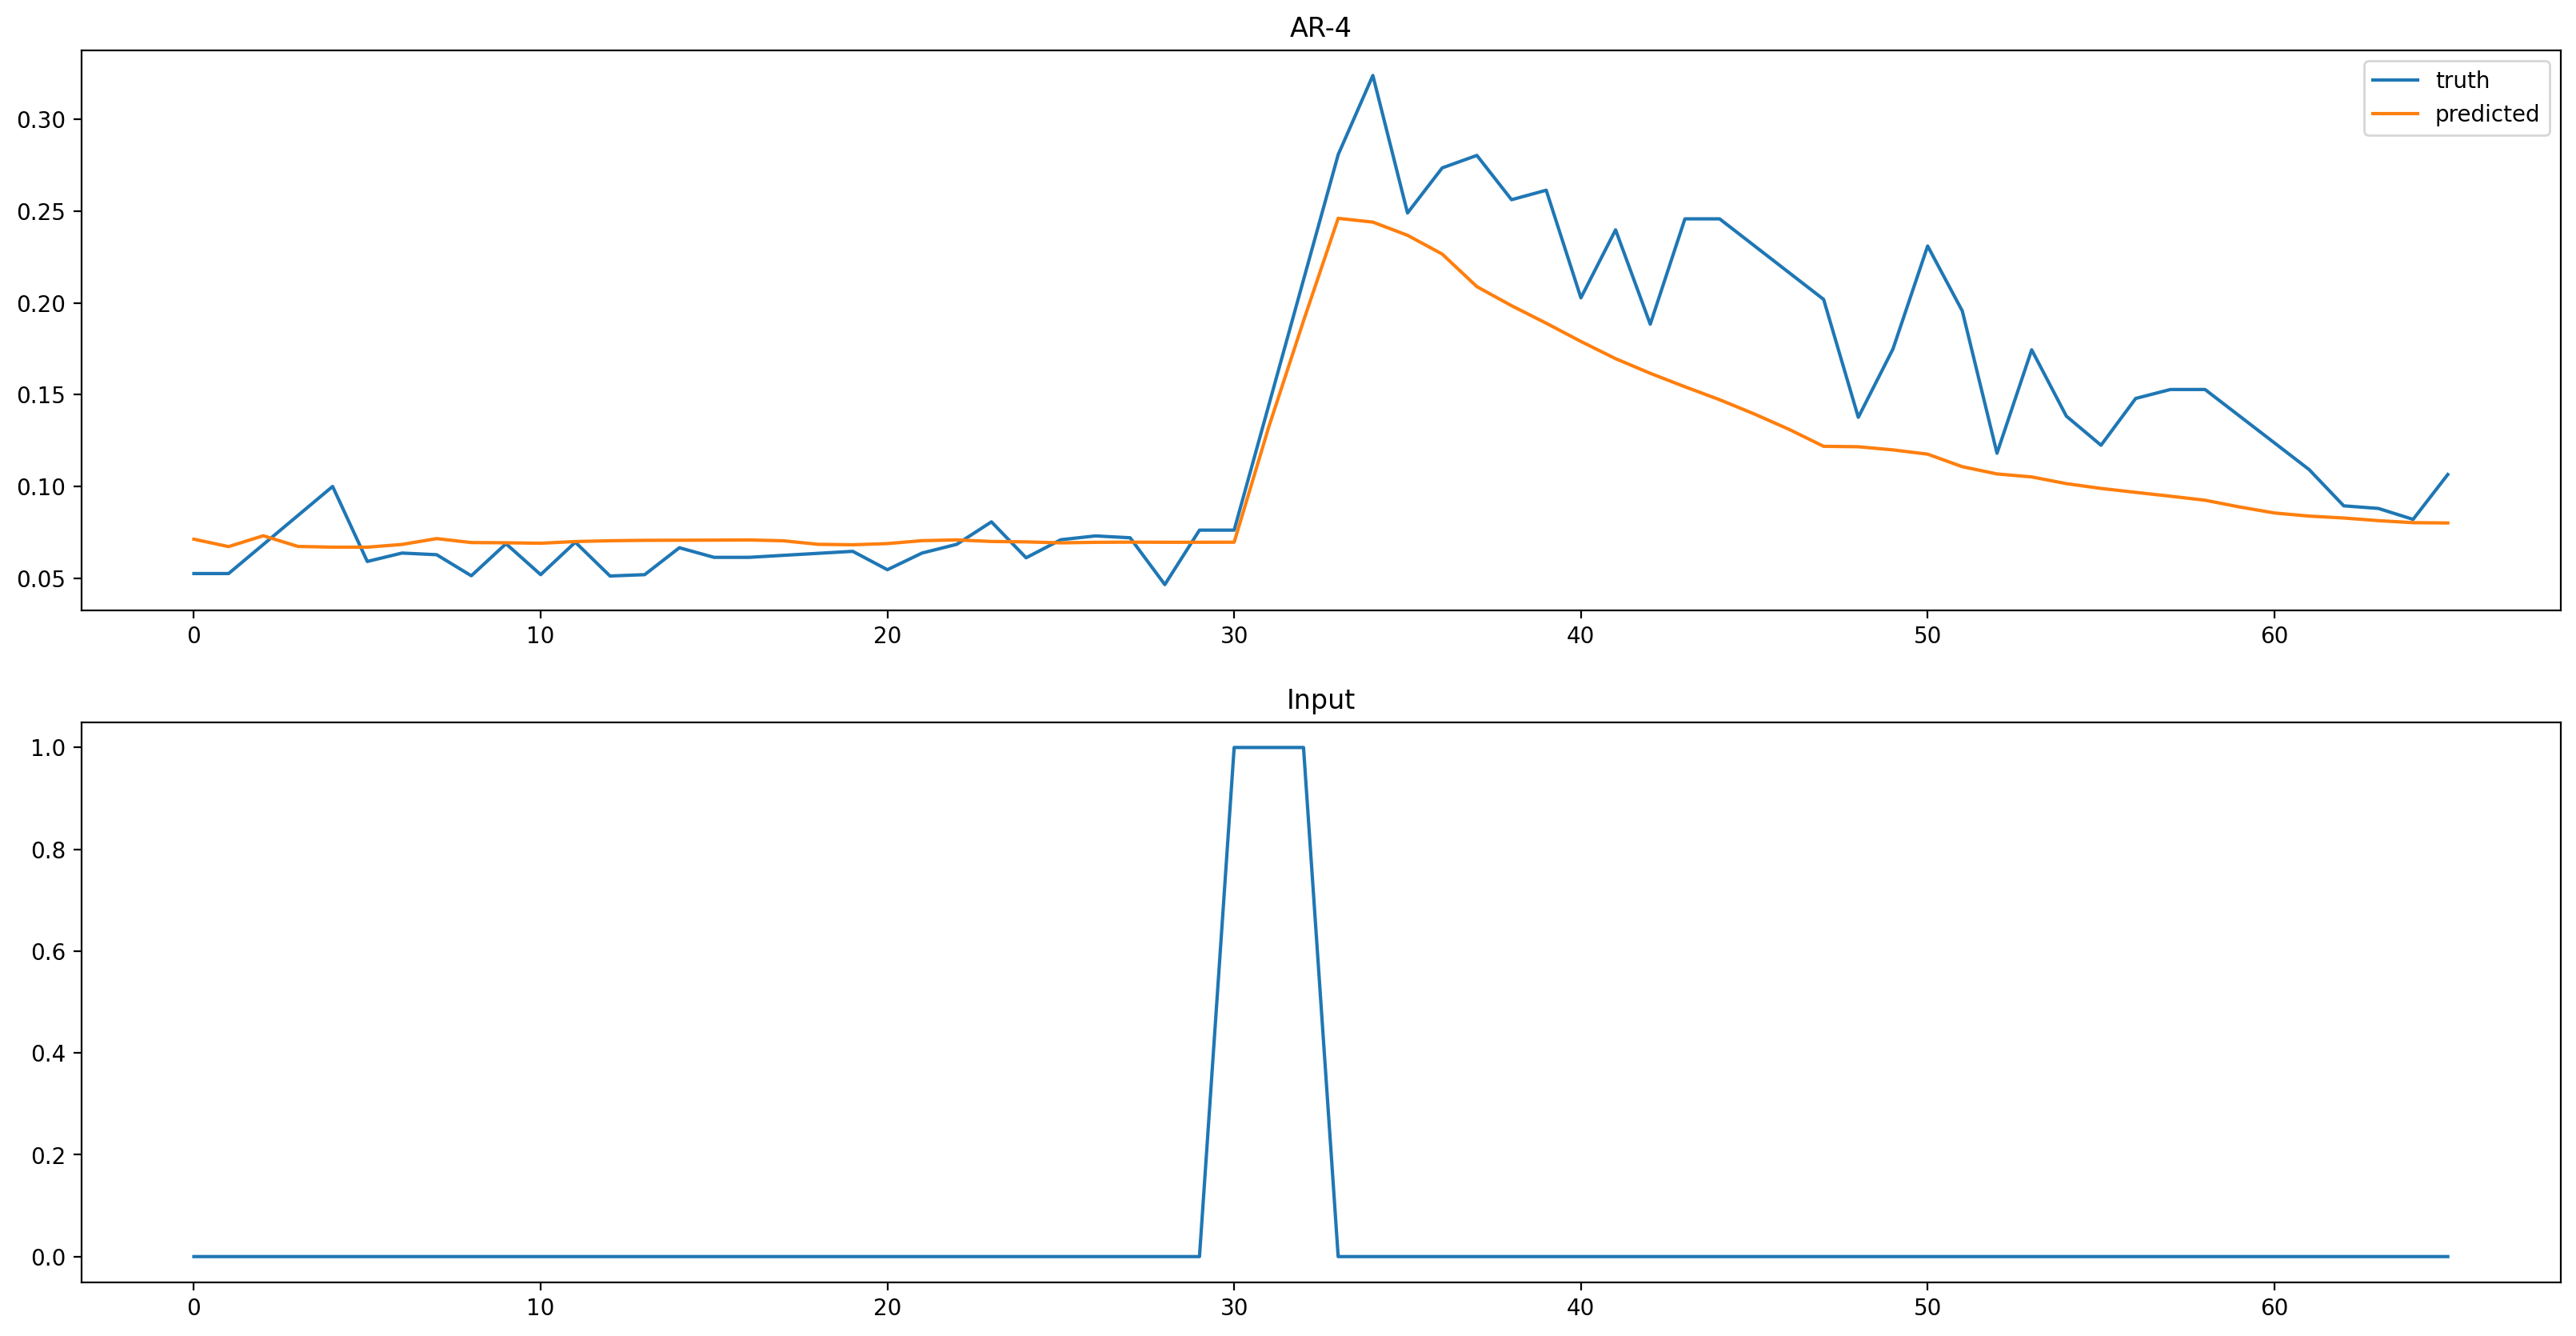

In [84]:
# linear model + test
neuron = 1
idx = 0

plt.figure(figsize=(20,10))
plt.subplot(2,1,1)
plt.plot(x_true[idx][:,neuron],label='truth')
plt.plot(x_pred[idx][:,neuron],label='predicted')
plt.title('AR-4')
plt.legend()

plt.subplot(2,1,2)
plt.plot(u_true[idx][:,neuron],label='input')
plt.title('Input')

Text(0.5, 1.0, 'Input')

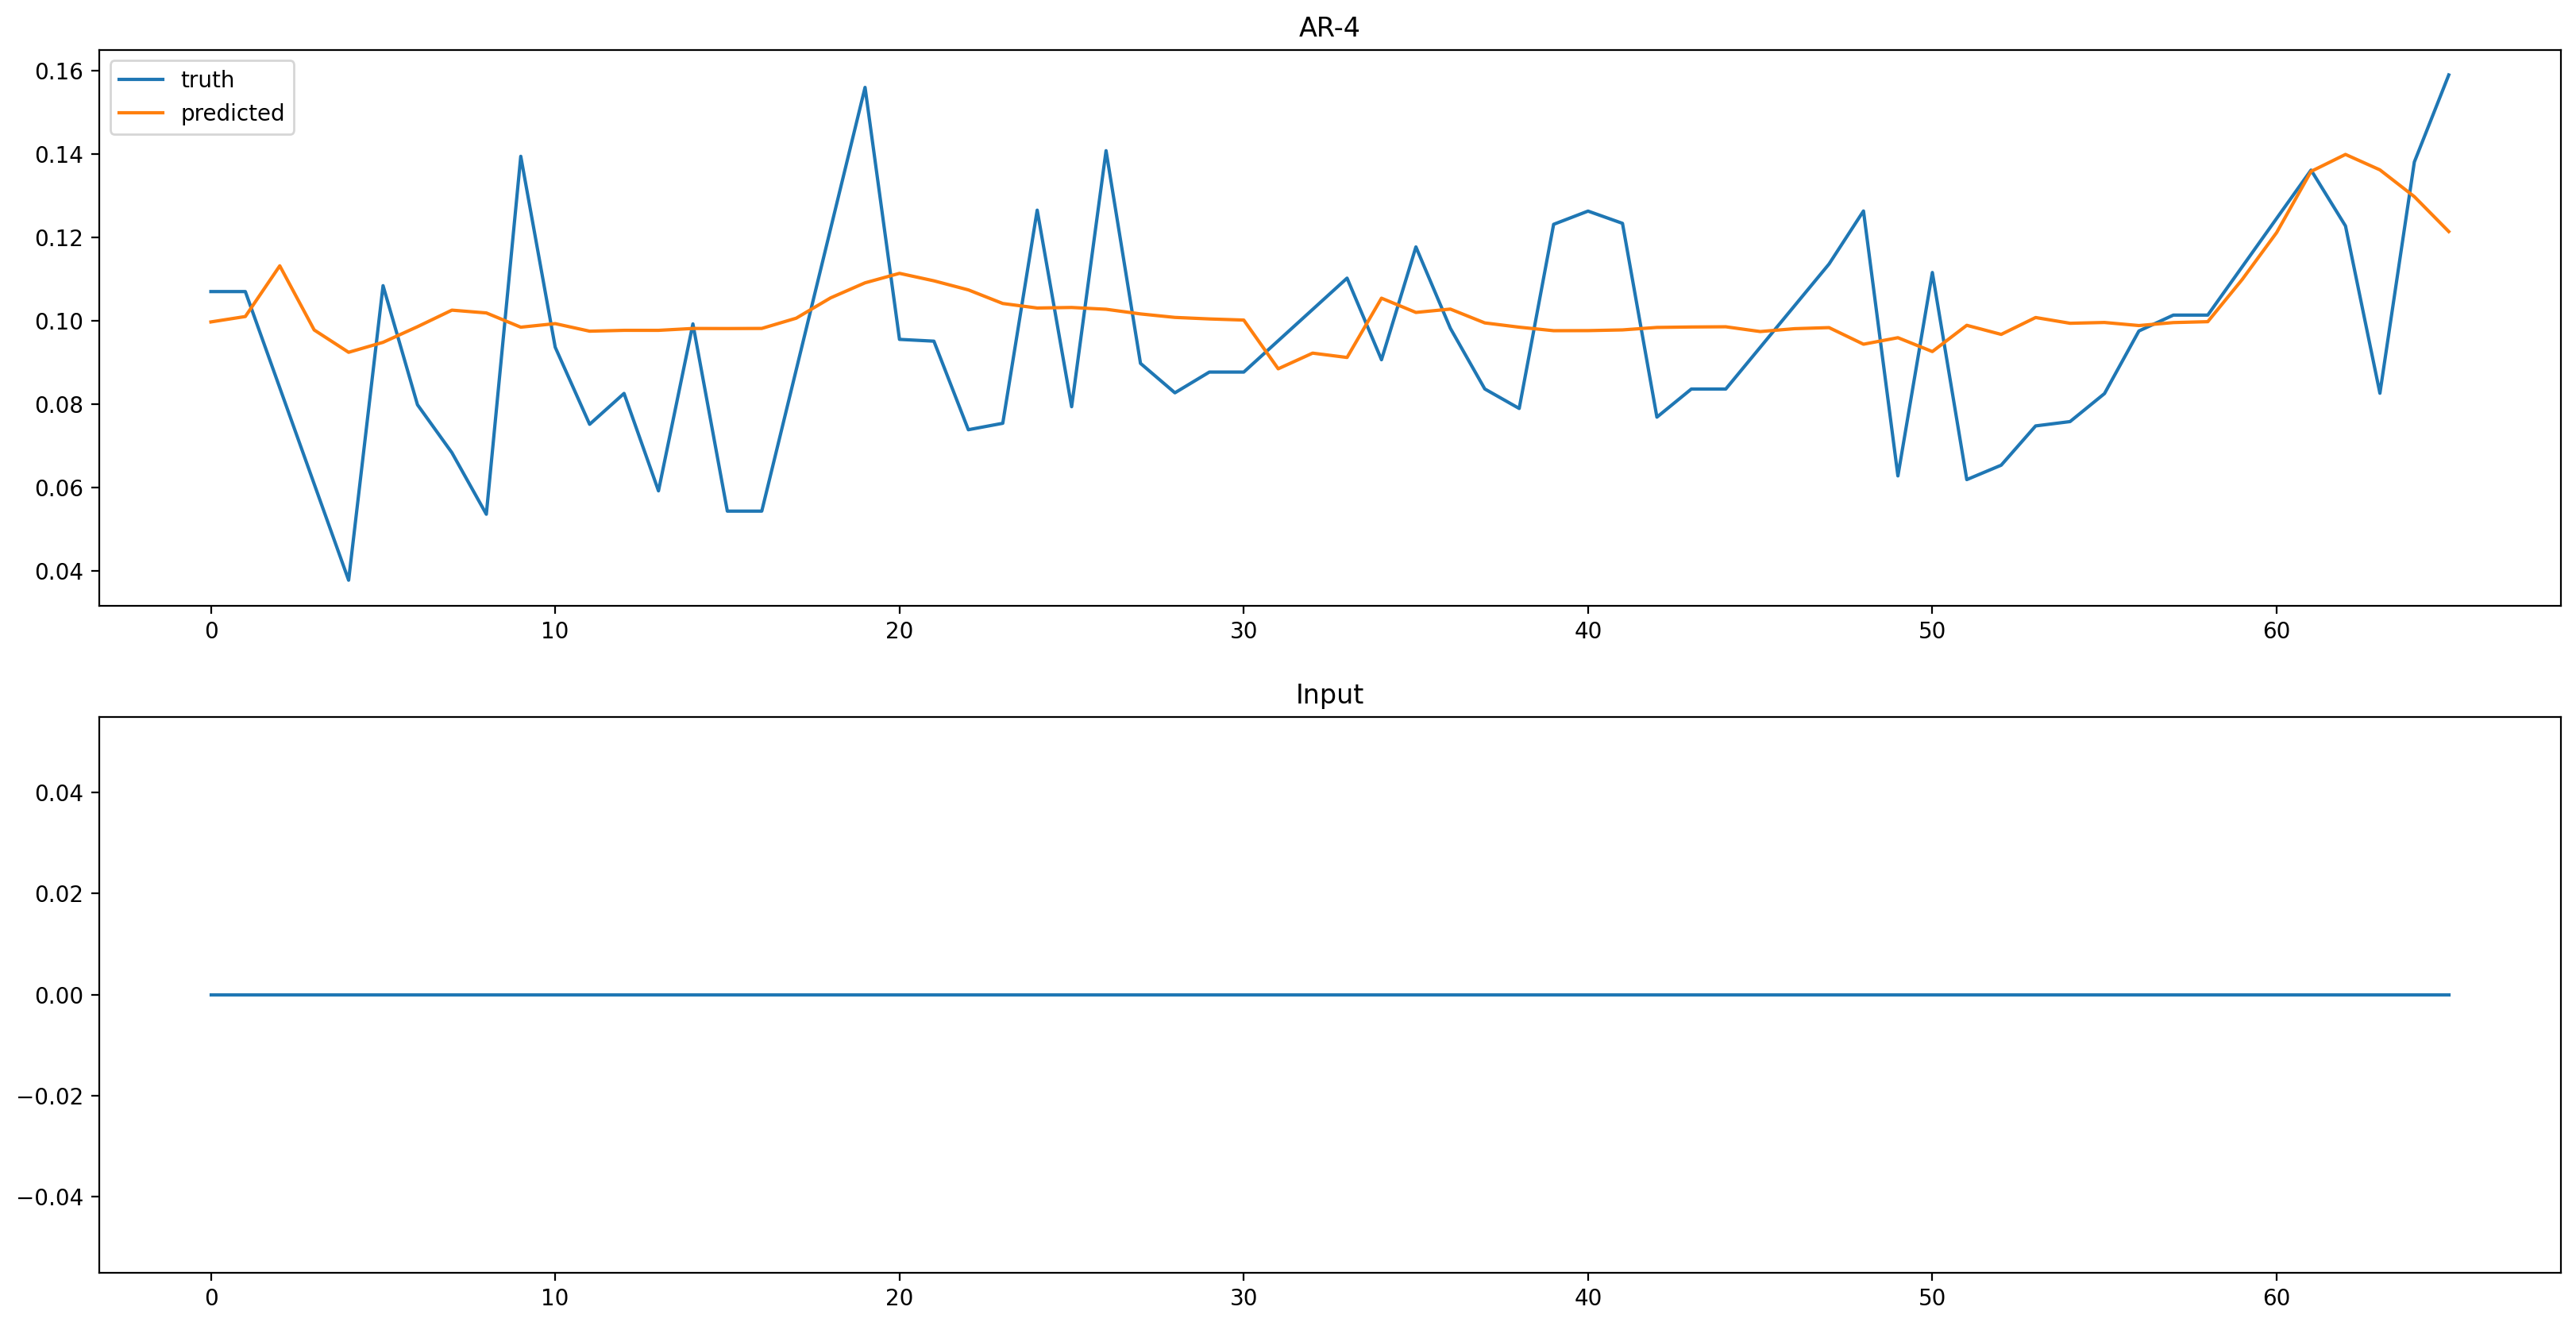

In [85]:
# linear model + test
neuron = 27
idx = 0

plt.figure(figsize=(20,10))
plt.subplot(2,1,1)
plt.plot(x_true[idx][:,neuron],label='truth')
plt.plot(x_pred[idx][:,neuron],label='predicted')
plt.title('AR-4')
plt.legend()

plt.subplot(2,1,2)
plt.plot(u_true[idx][:,neuron],label='input')
plt.title('Input')

Text(0.5, 1.0, 'Input')

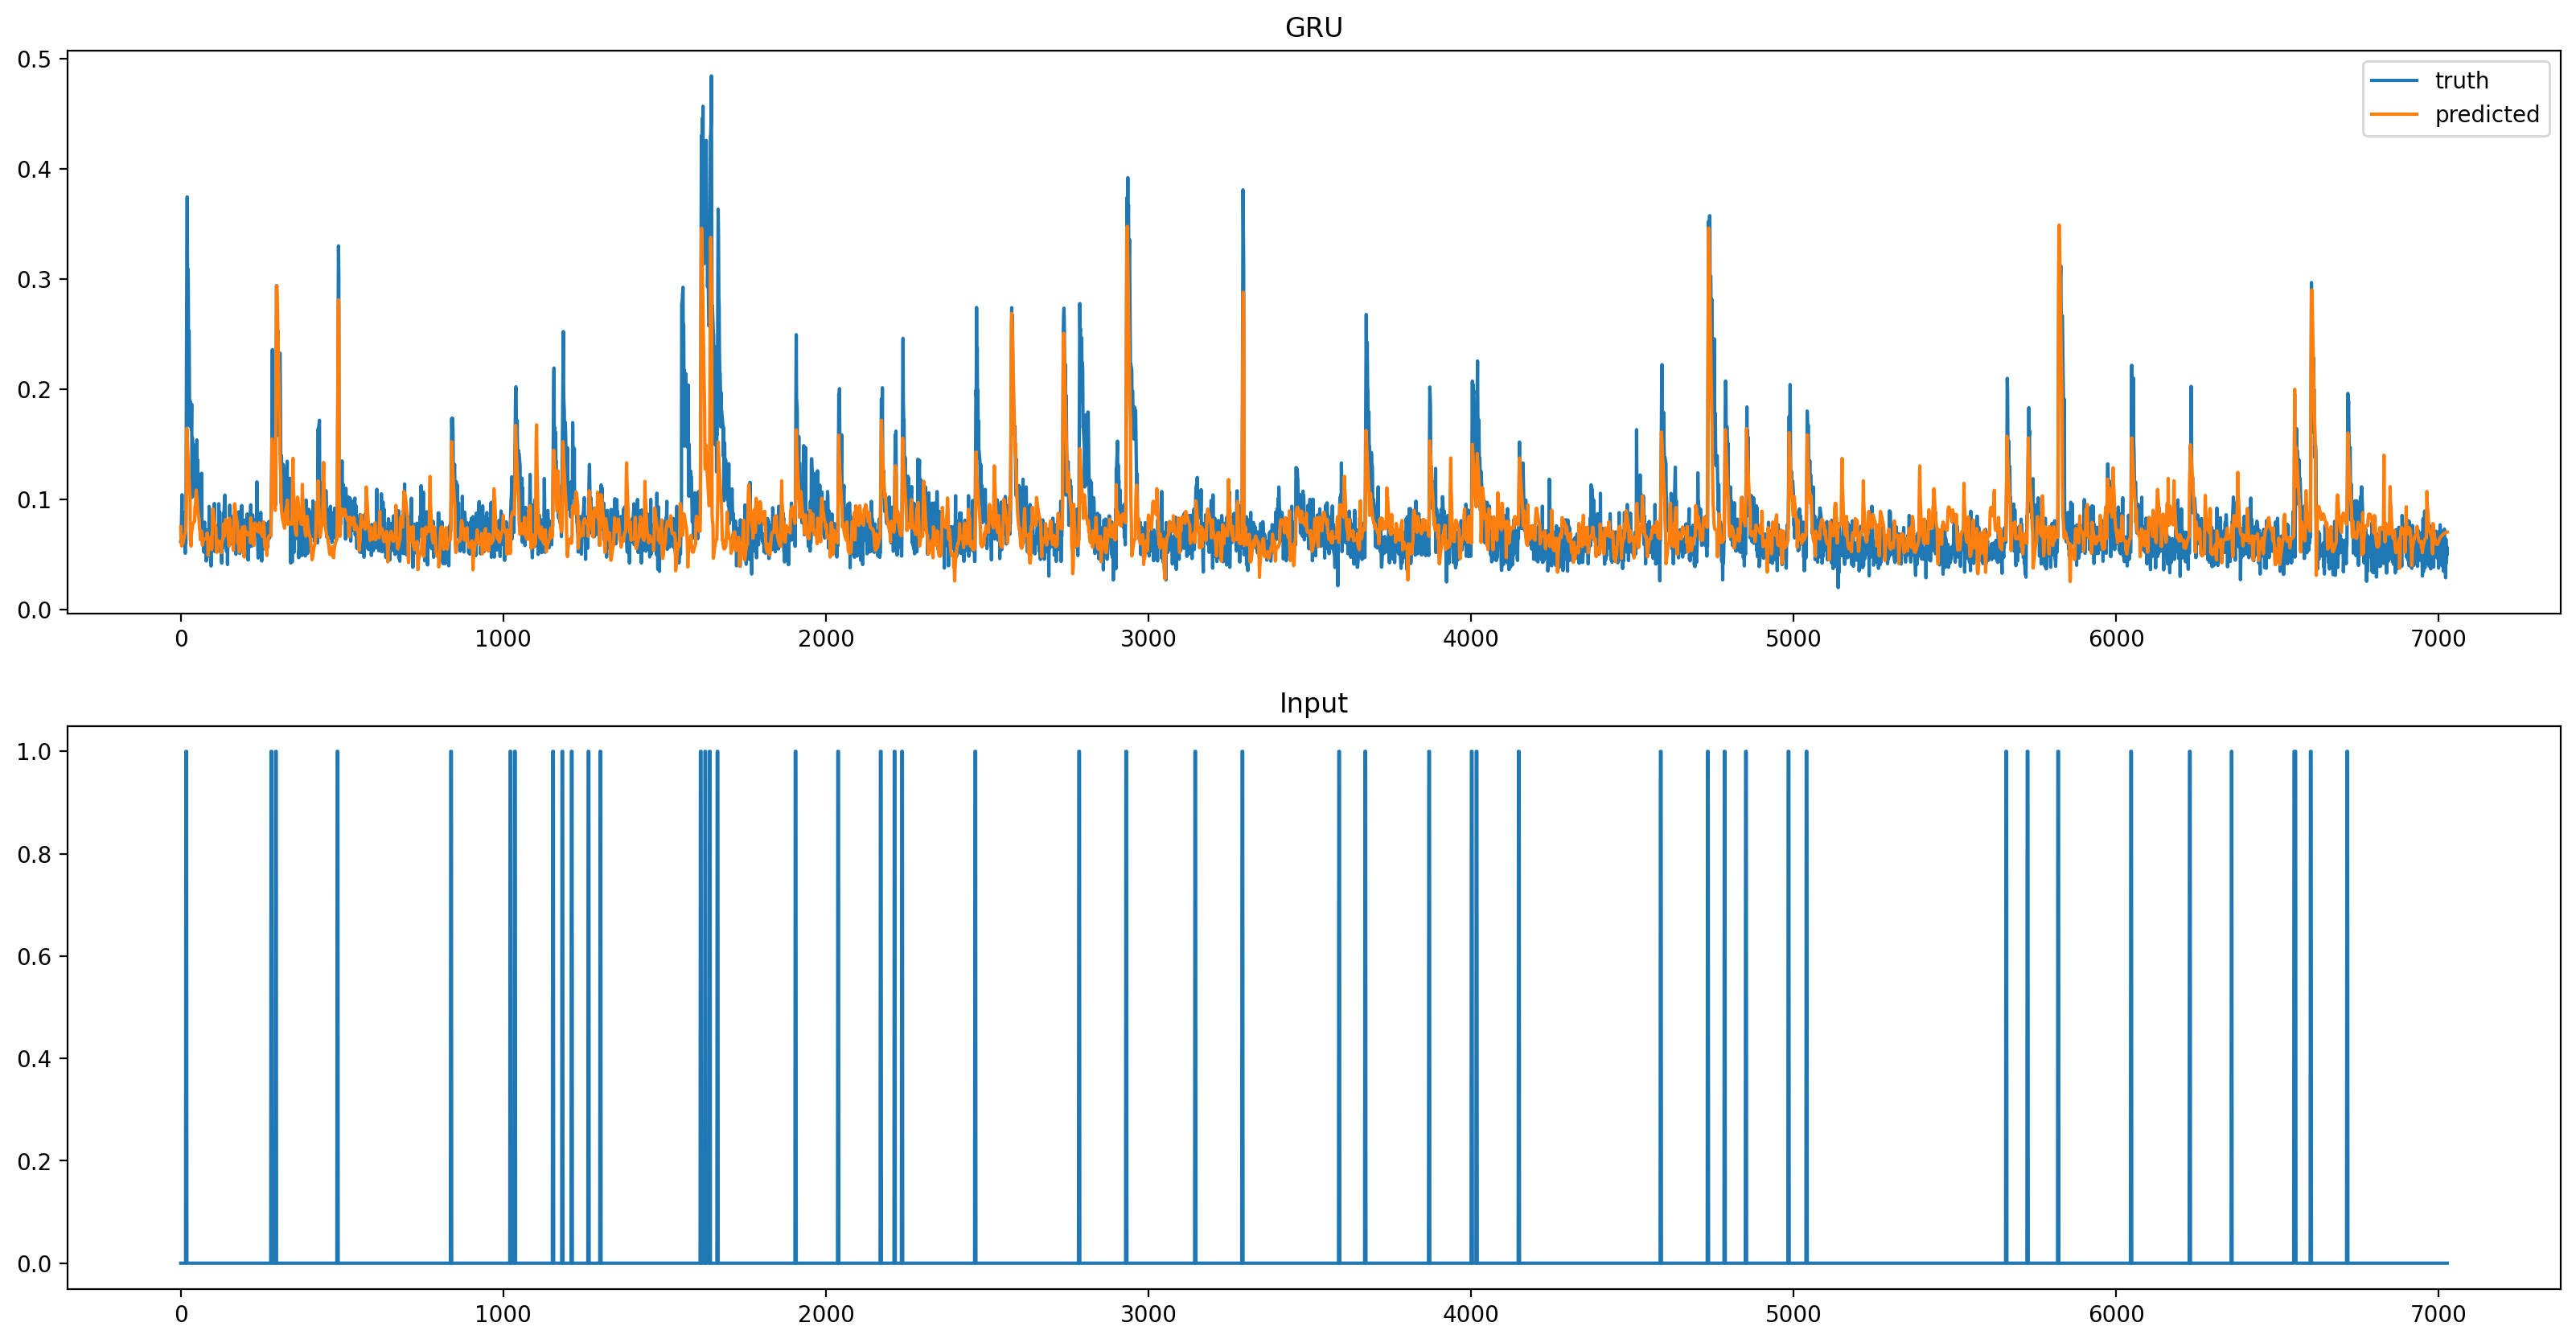

In [105]:
# deep model
neuron = removed_neurons[9]
length = 10000

output_pred = []
output_true = []
input_true = []
segment_marker = []

for i in range(np.min([len(x_true),length])):
    output_pred.extend(x_pred[i][:,neuron])
    #output_pred.append(np.nan)
    output_true.extend(x_true[i][:,neuron])
    #output_true.append(np.nan)
    input_true.extend(u_true[i][:,neuron])
    #input_true.append(np.nan)
    segment_marker.extend(np.nan*np.zeros(len(x_pred[i][:,neuron])-1))
    segment_marker.extend([0.25,0])
    
plt.figure(figsize=(20,10))
plt.subplot(2,1,1)
plt.plot(output_true,label='truth')
plt.plot(output_pred,label='predicted')
#plt.plot(segment_marker)
plt.title('GRU')
plt.legend()

plt.subplot(2,1,2)
plt.plot(input_true,label='input')
plt.title('Input')

Text(0.5, 1.0, 'Input')

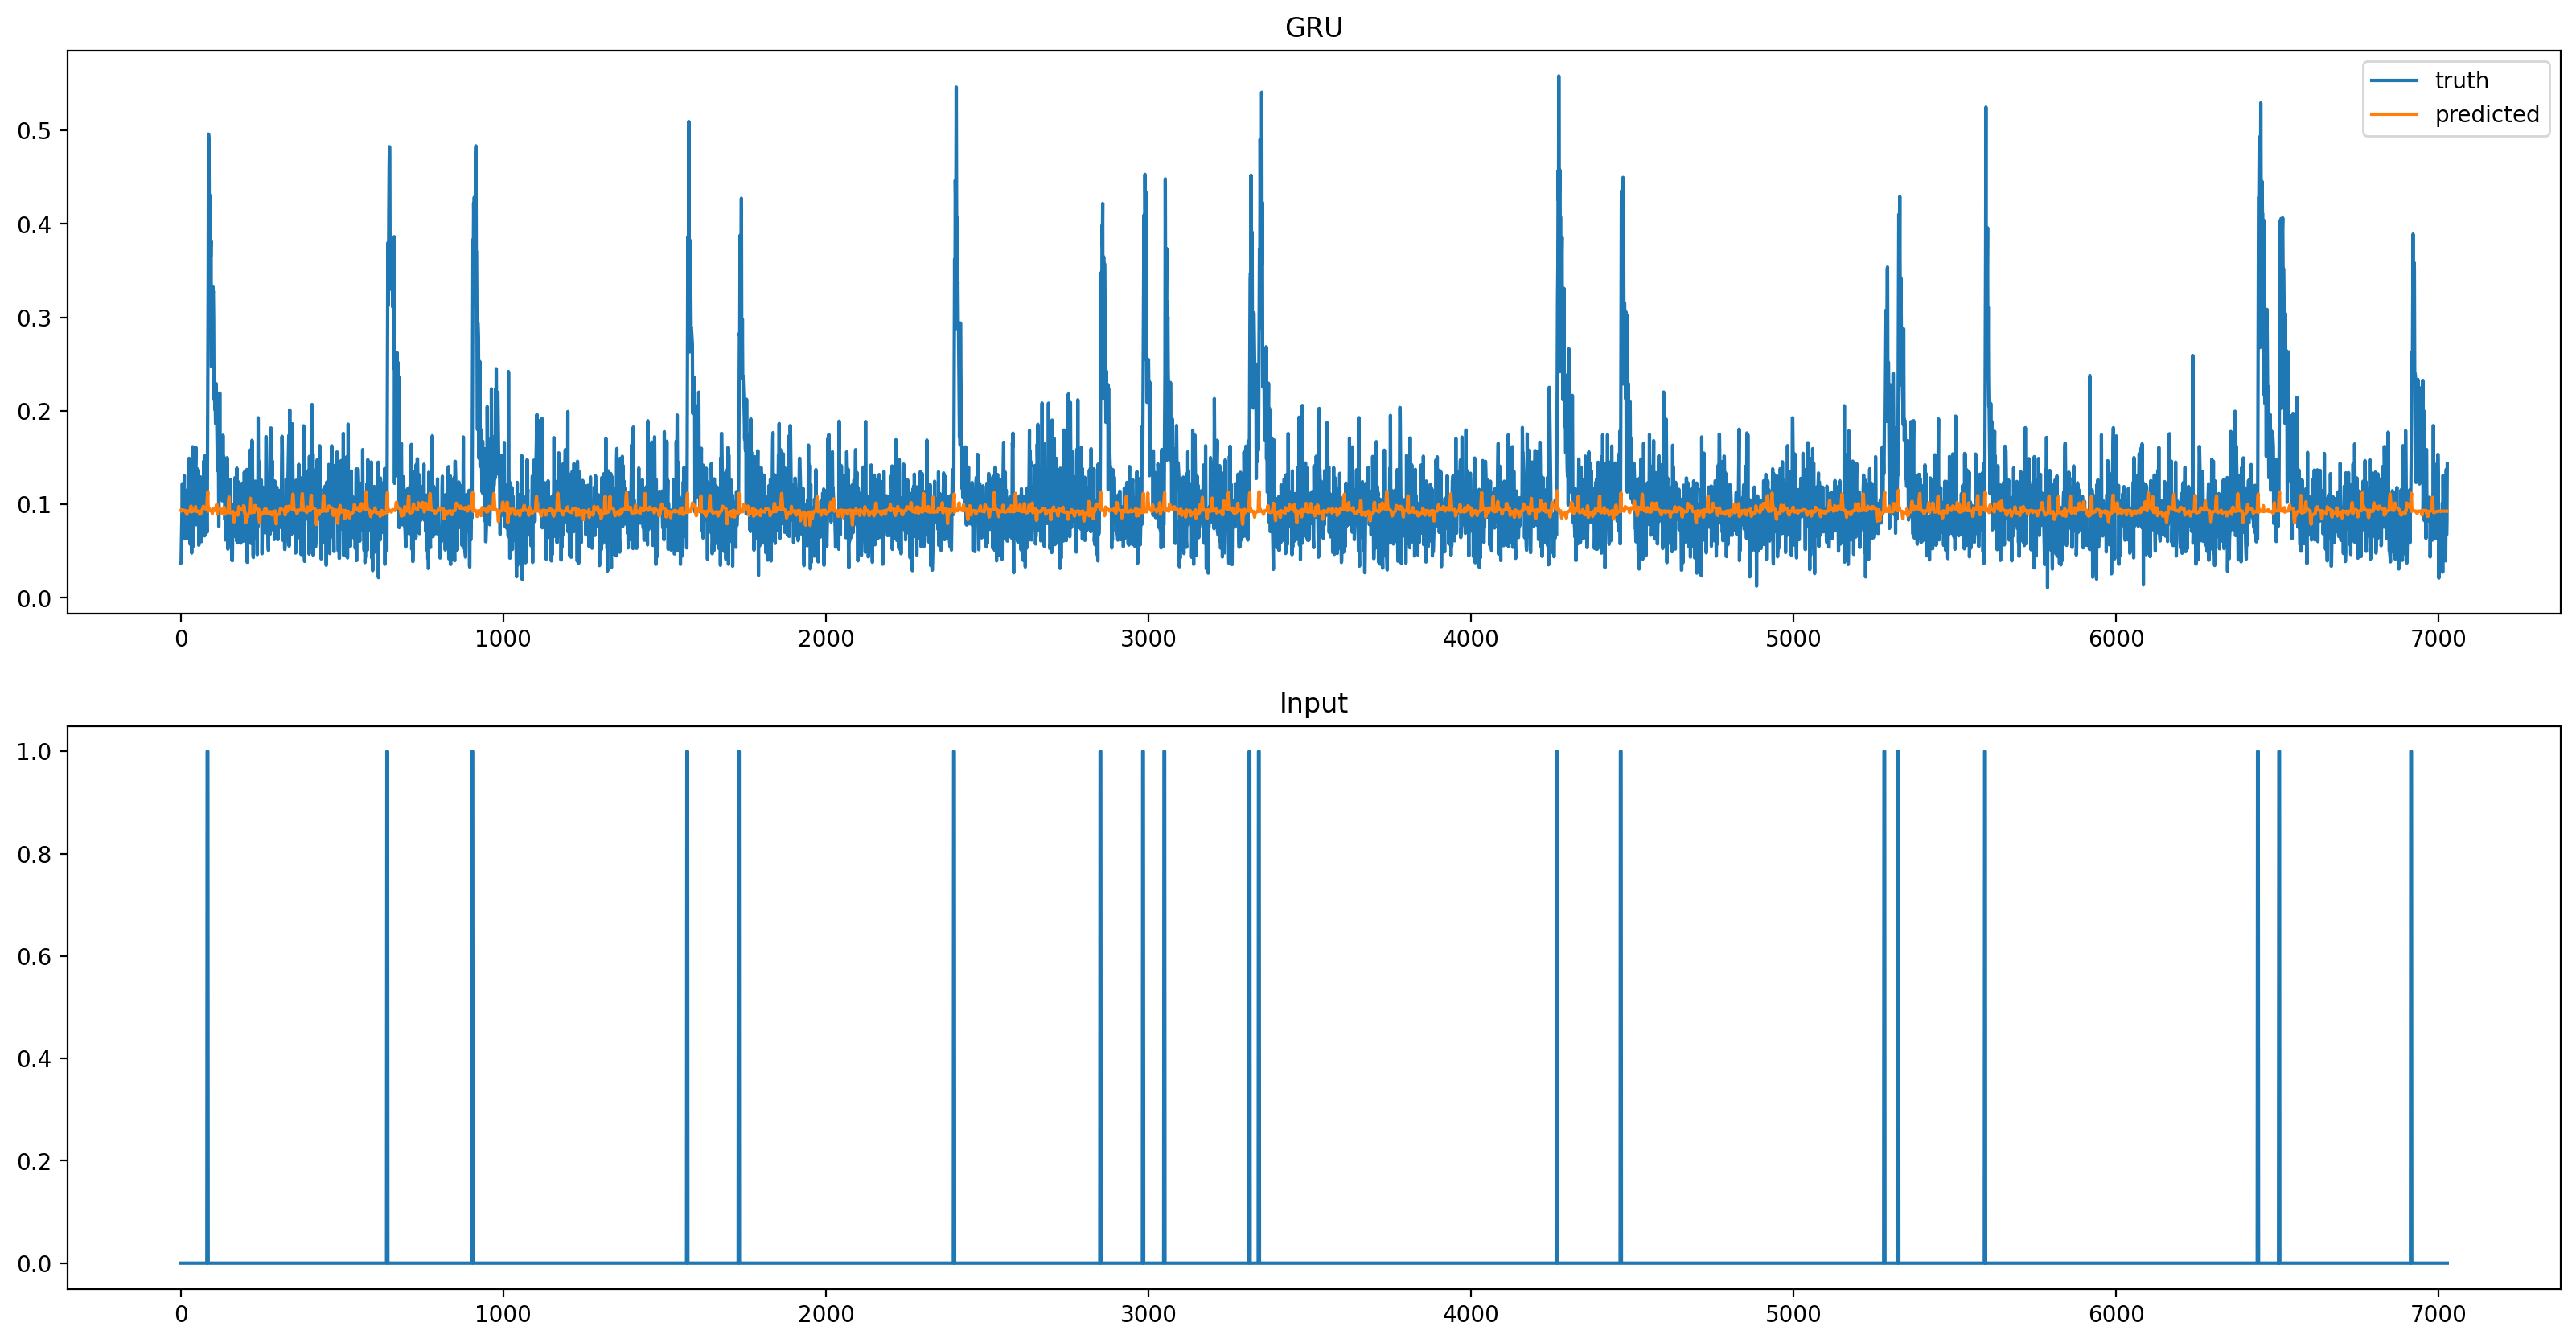

In [106]:
# deep model
neuron = removed_neurons[6]
length = 10000

output_pred = []
output_true = []
input_true = []
segment_marker = []

for i in range(np.min([len(x_true),length])):
    output_pred.extend(x_pred[i][:,neuron])
    #output_pred.append(np.nan)
    output_true.extend(x_true[i][:,neuron])
    #output_true.append(np.nan)
    input_true.extend(u_true[i][:,neuron])
    #input_true.append(np.nan)
    segment_marker.extend(np.nan*np.zeros(len(x_pred[i][:,neuron])-1))
    segment_marker.extend([0.25,0])
    
plt.figure(figsize=(20,10))
plt.subplot(2,1,1)
plt.plot(output_true,label='truth')
plt.plot(output_pred,label='predicted')
#plt.plot(segment_marker)
plt.title('GRU')
plt.legend()

plt.subplot(2,1,2)
plt.plot(input_true,label='input')
plt.title('Input')

Text(0.5, 1.0, 'Input')

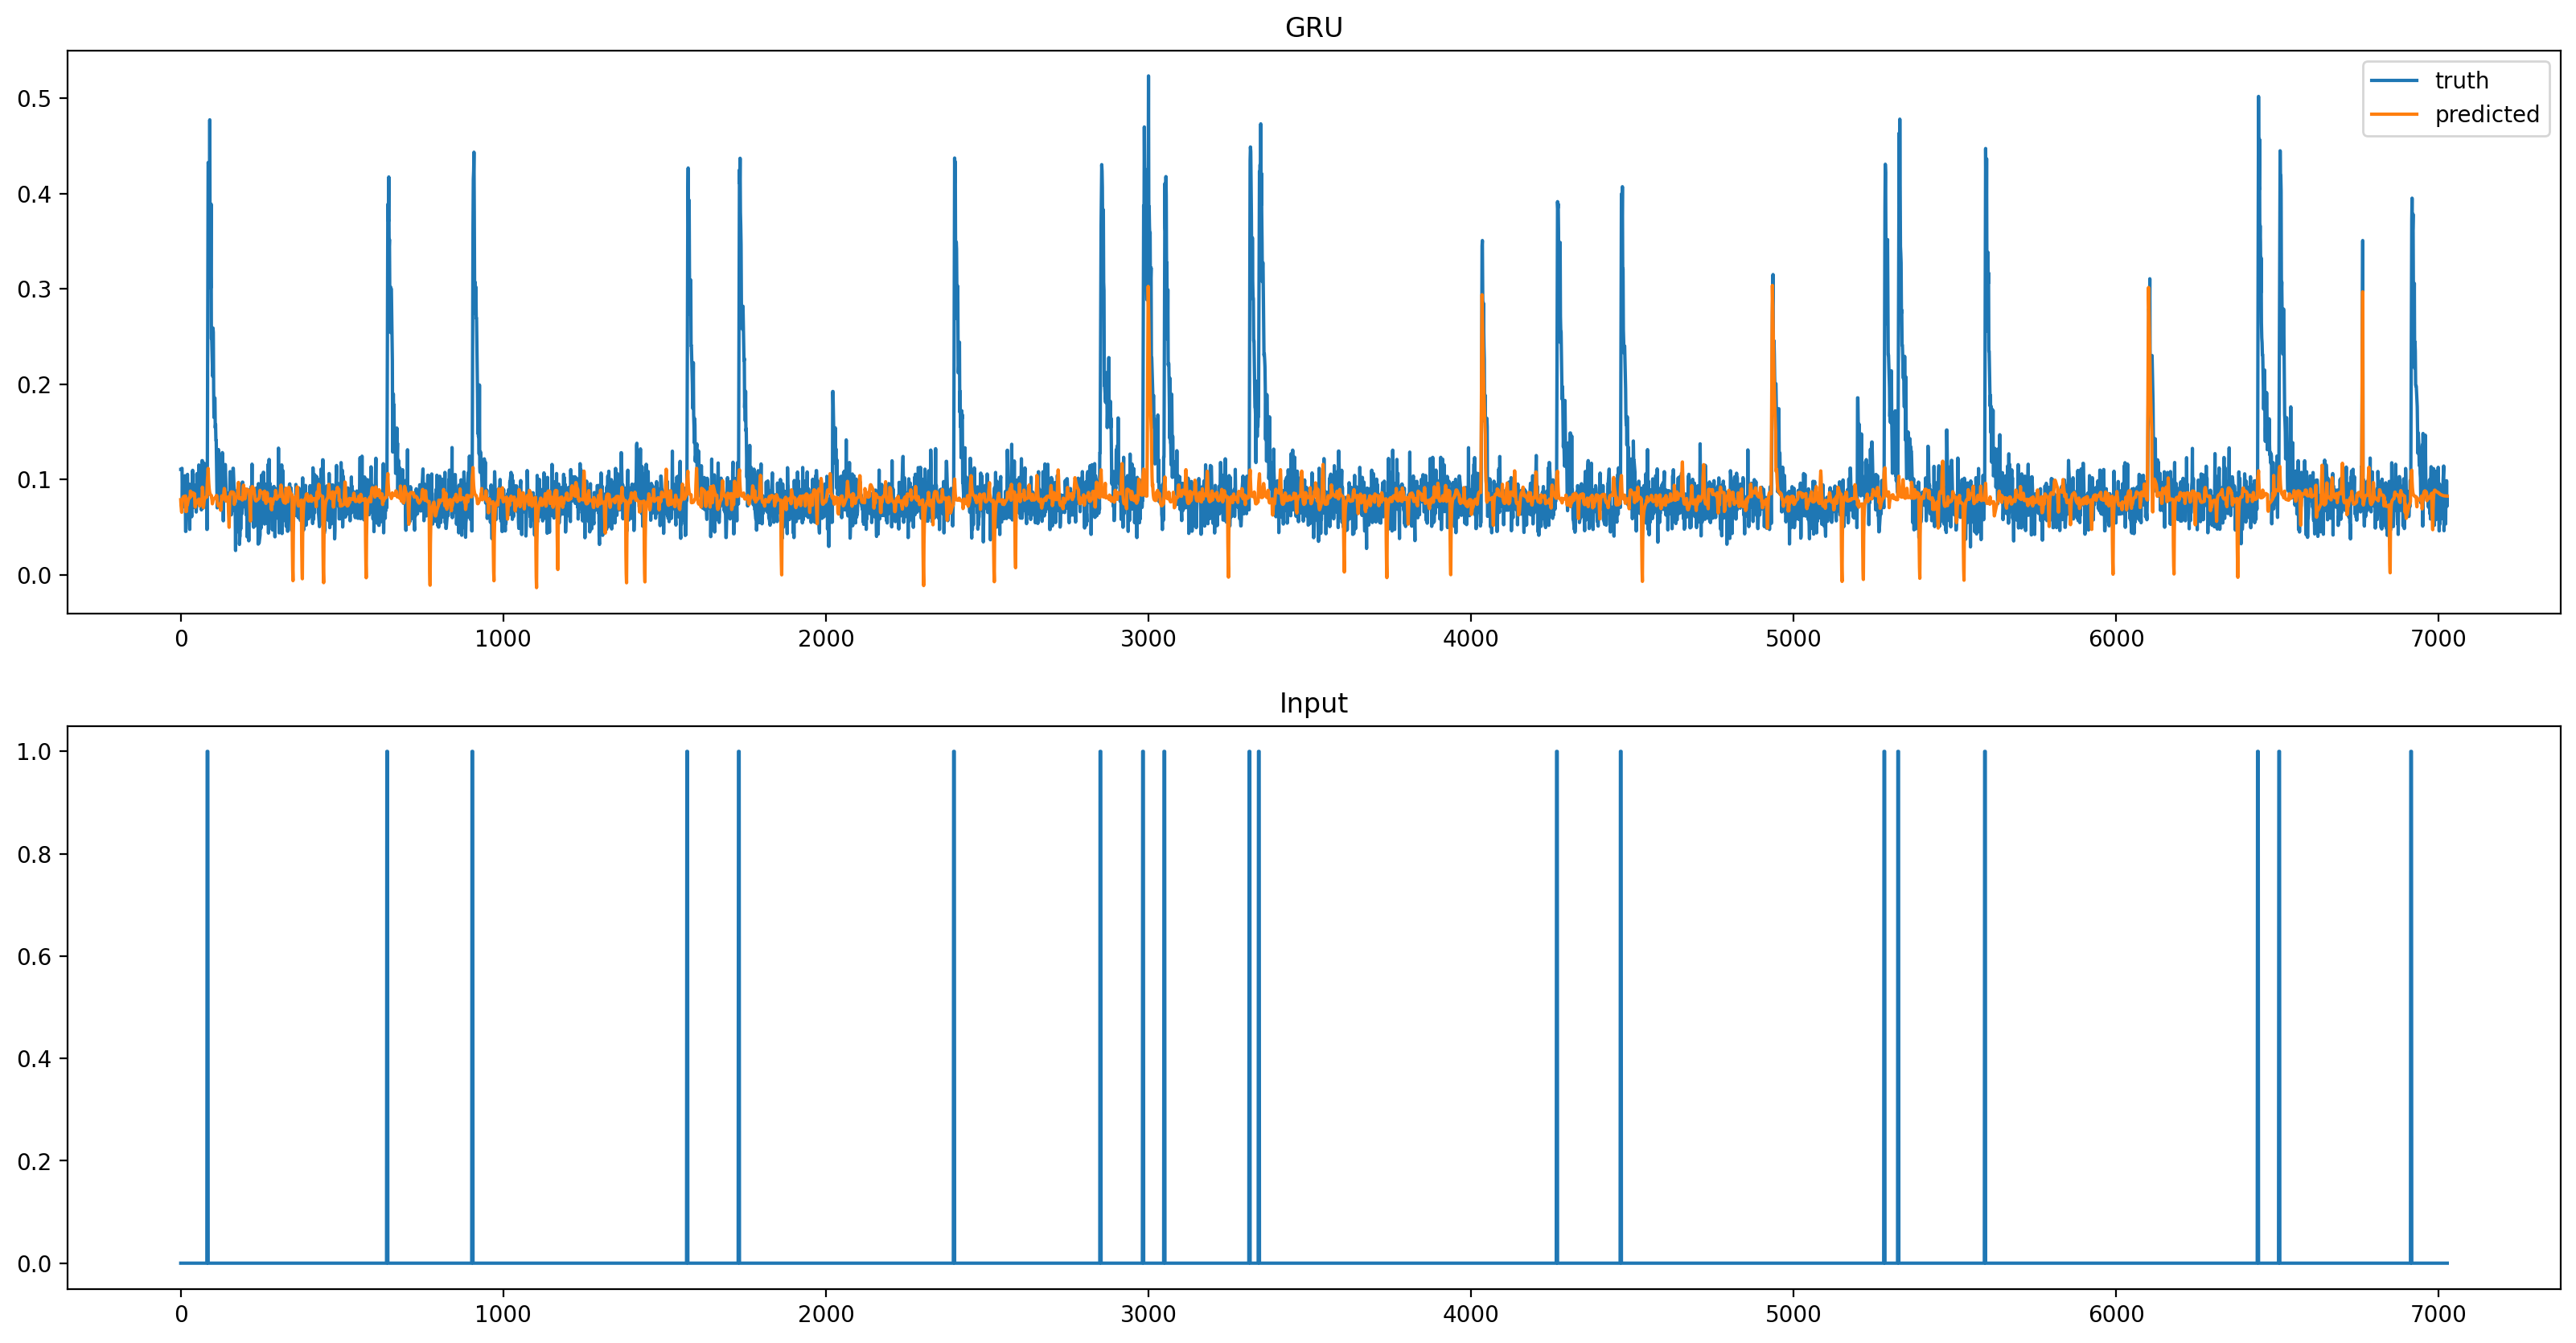

In [107]:
# deep model
neuron = removed_neurons[3]
length = 10000

output_pred = []
output_true = []
input_true = []
segment_marker = []

for i in range(np.min([len(x_true),length])):
    output_pred.extend(x_pred[i][:,neuron])
    #output_pred.append(np.nan)
    output_true.extend(x_true[i][:,neuron])
    #output_true.append(np.nan)
    input_true.extend(u_true[i][:,neuron])
    #input_true.append(np.nan)
    segment_marker.extend(np.nan*np.zeros(len(x_pred[i][:,neuron])-1))
    segment_marker.extend([0.25,0])
    
plt.figure(figsize=(20,10))
plt.subplot(2,1,1)
plt.plot(output_true,label='truth')
plt.plot(output_pred,label='predicted')
#plt.plot(segment_marker)
plt.title('GRU')
plt.legend()

plt.subplot(2,1,2)
plt.plot(input_true,label='input')
plt.title('Input')

Text(0.5, 1.0, 'Input')

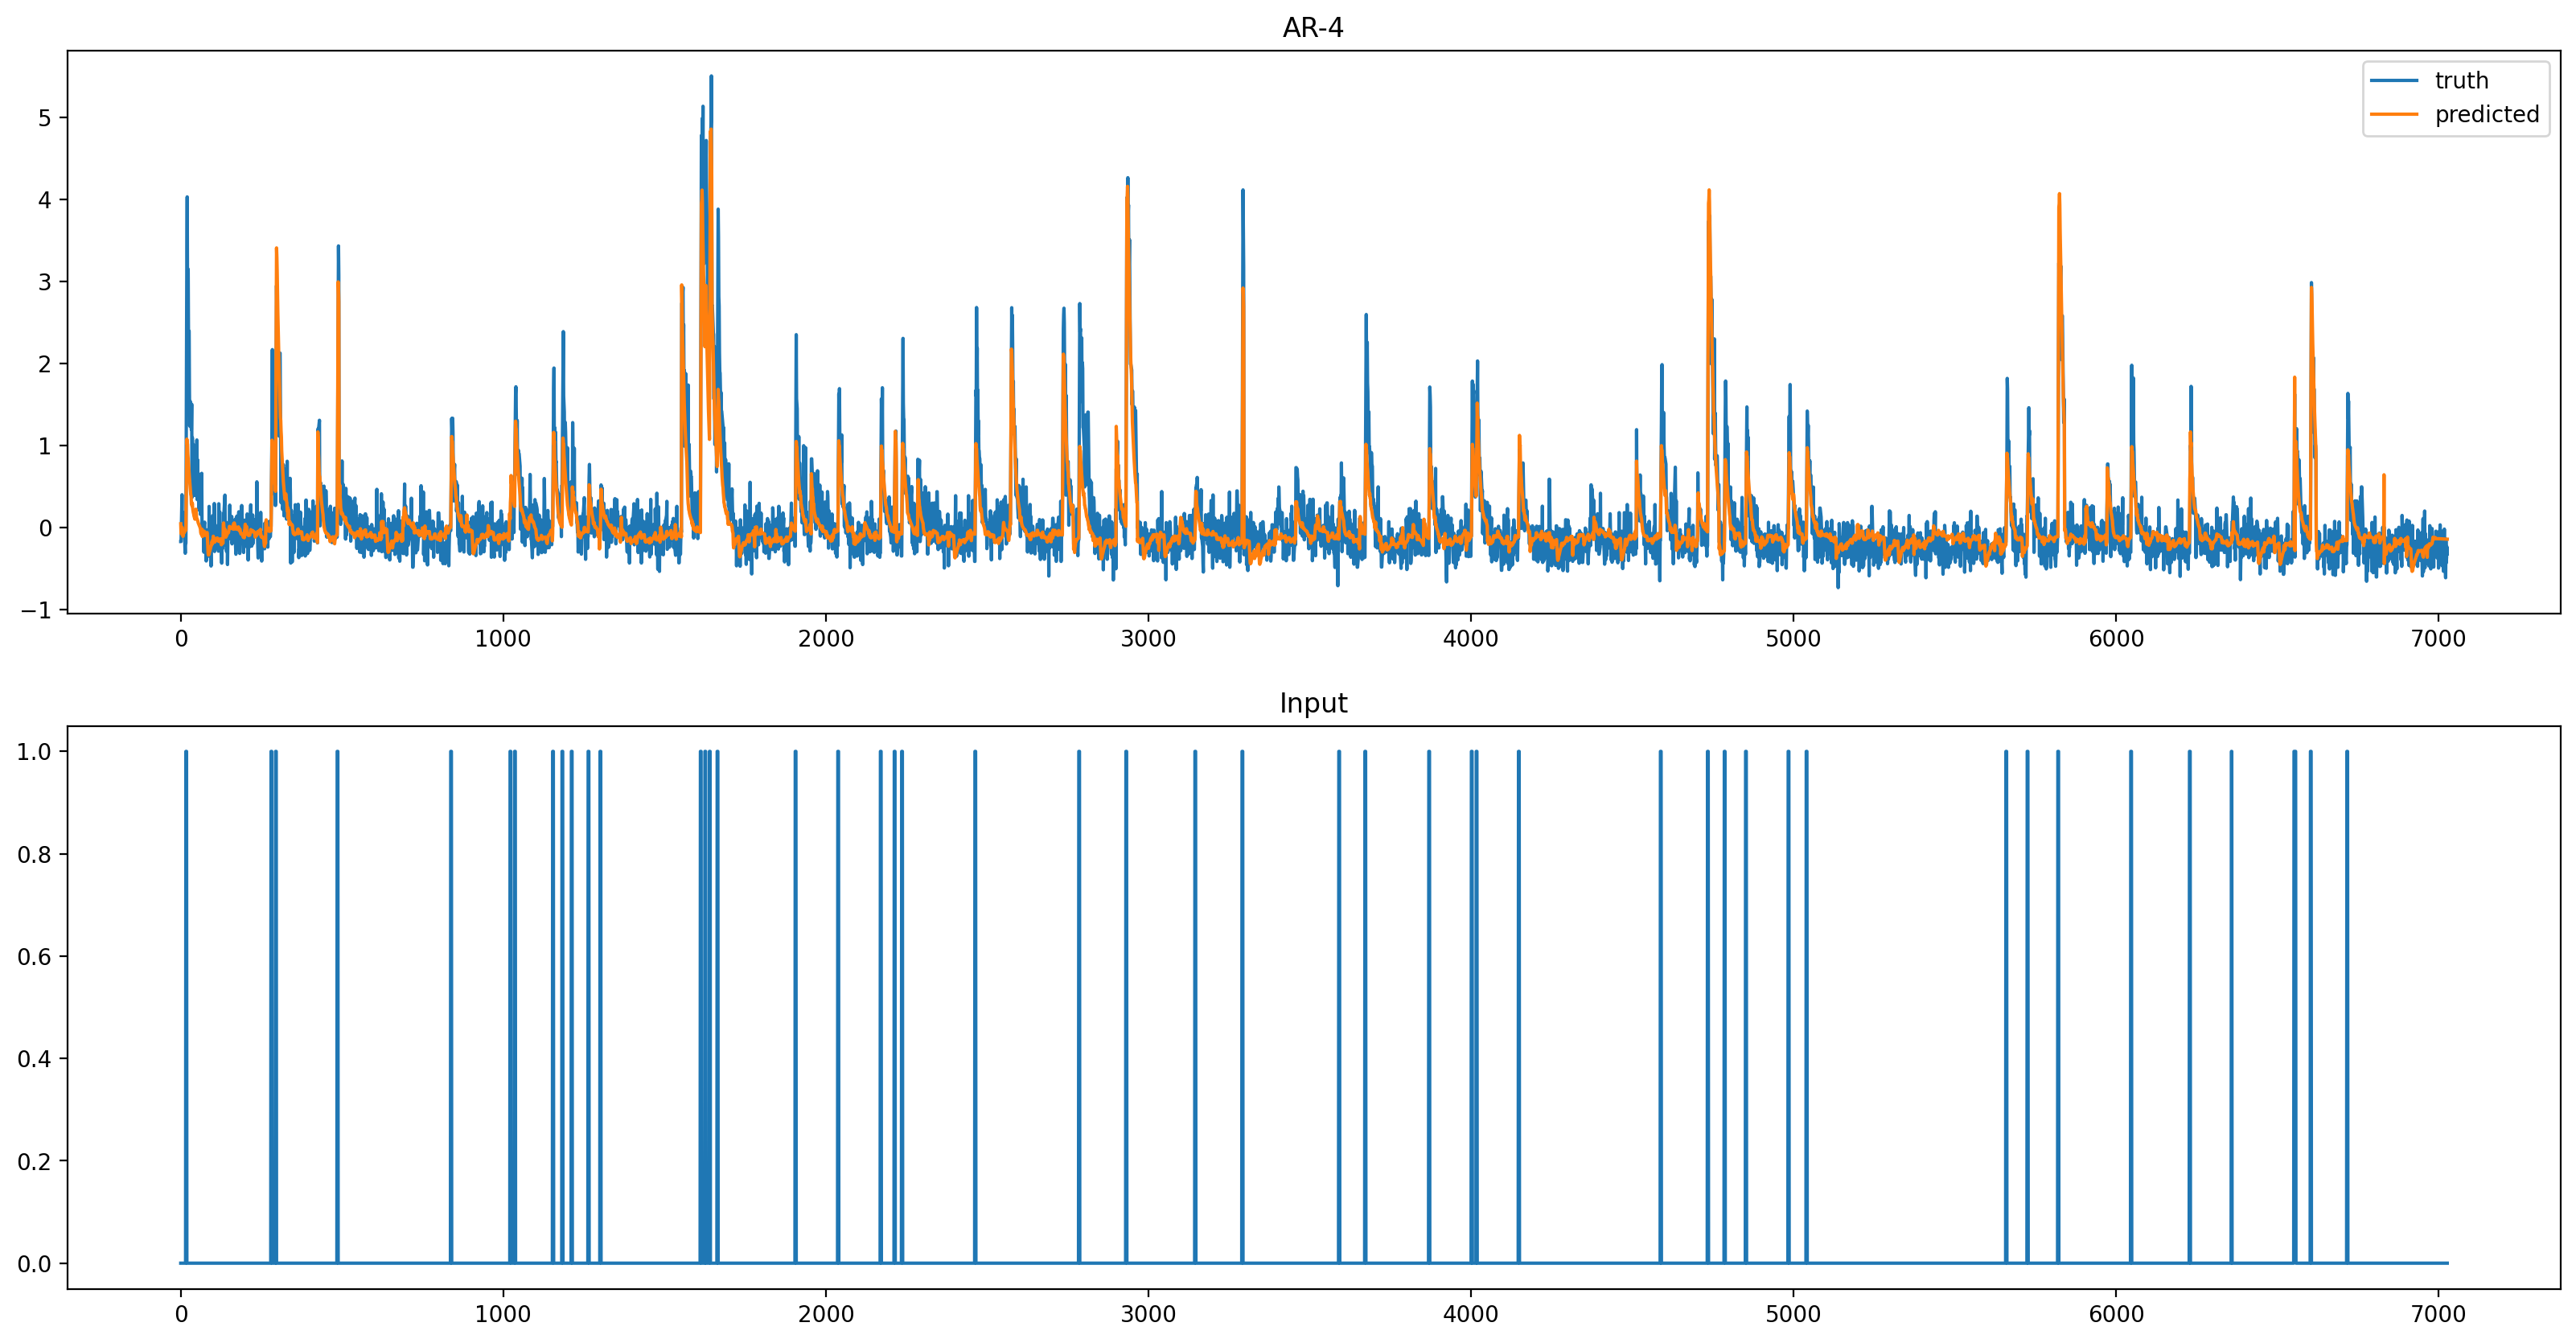

In [31]:
# linear model
neuron = removed_neurons[9]
length = 10000

output_pred = []
output_true = []
input_true = []
segment_marker = []

for i in range(np.min([len(x_true),length])):
    output_pred.extend(x_pred[i][:,neuron])
    #output_pred.append(np.nan)
    output_true.extend(x_true[i][:,neuron])
    #output_true.append(np.nan)
    input_true.extend(u_true[i][:,neuron])
    #input_true.append(np.nan)
    segment_marker.extend(np.nan*np.zeros(len(x_pred[i][:,neuron])-1))
    segment_marker.extend([0.25,0])
    
plt.figure(figsize=(20,10))
plt.subplot(2,1,1)
plt.plot(output_true,label='truth')
plt.plot(output_pred,label='predicted')
#plt.plot(segment_marker)
plt.title('AR-4')
plt.legend()

plt.subplot(2,1,2)
plt.plot(input_true,label='input')
plt.title('Input')

Text(0.5, 1.0, 'Input')

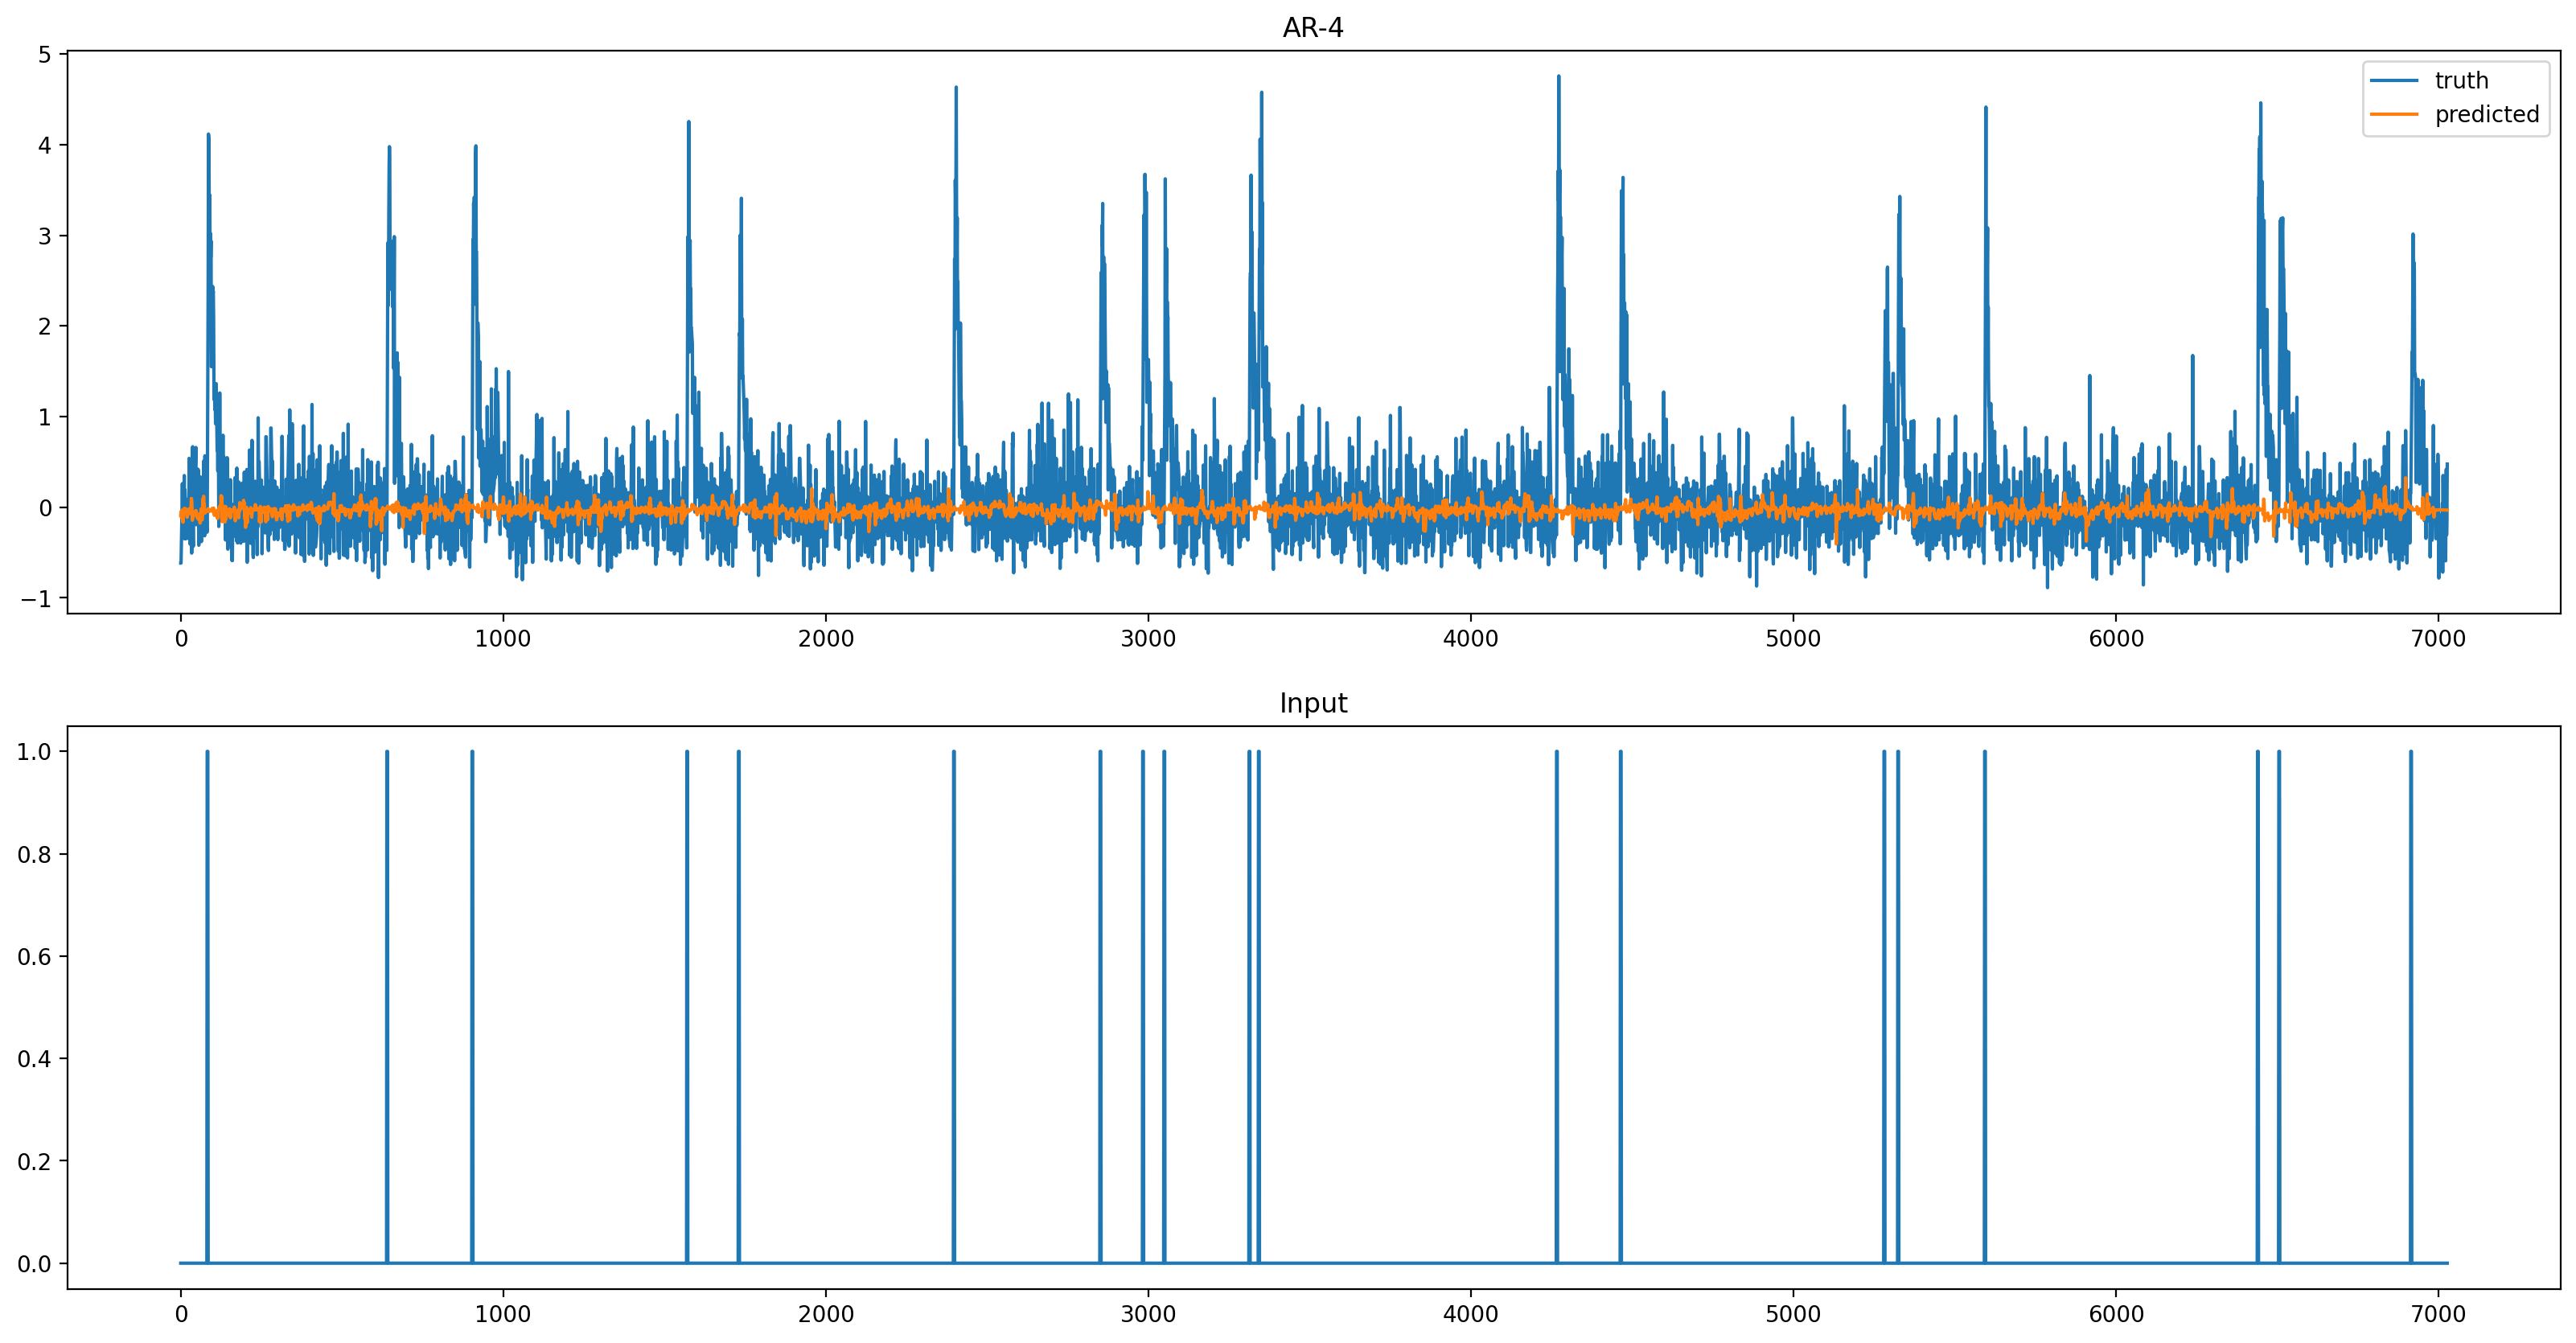

In [32]:
# linear model
neuron = removed_neurons[6]
length = 10000

output_pred = []
output_true = []
input_true = []
segment_marker = []

for i in range(np.min([len(x_true),length])):
    output_pred.extend(x_pred[i][:,neuron])
    #output_pred.append(np.nan)
    output_true.extend(x_true[i][:,neuron])
    #output_true.append(np.nan)
    input_true.extend(u_true[i][:,neuron])
    #input_true.append(np.nan)
    segment_marker.extend(np.nan*np.zeros(len(x_pred[i][:,neuron])-1))
    segment_marker.extend([0.25,0])
    
plt.figure(figsize=(20,10))
plt.subplot(2,1,1)
plt.plot(output_true,label='truth')
plt.plot(output_pred,label='predicted')
#plt.plot(segment_marker)
plt.title('AR-4')
plt.legend()

plt.subplot(2,1,2)
plt.plot(input_true,label='input')
plt.title('Input')

Text(0.5, 1.0, 'Input')

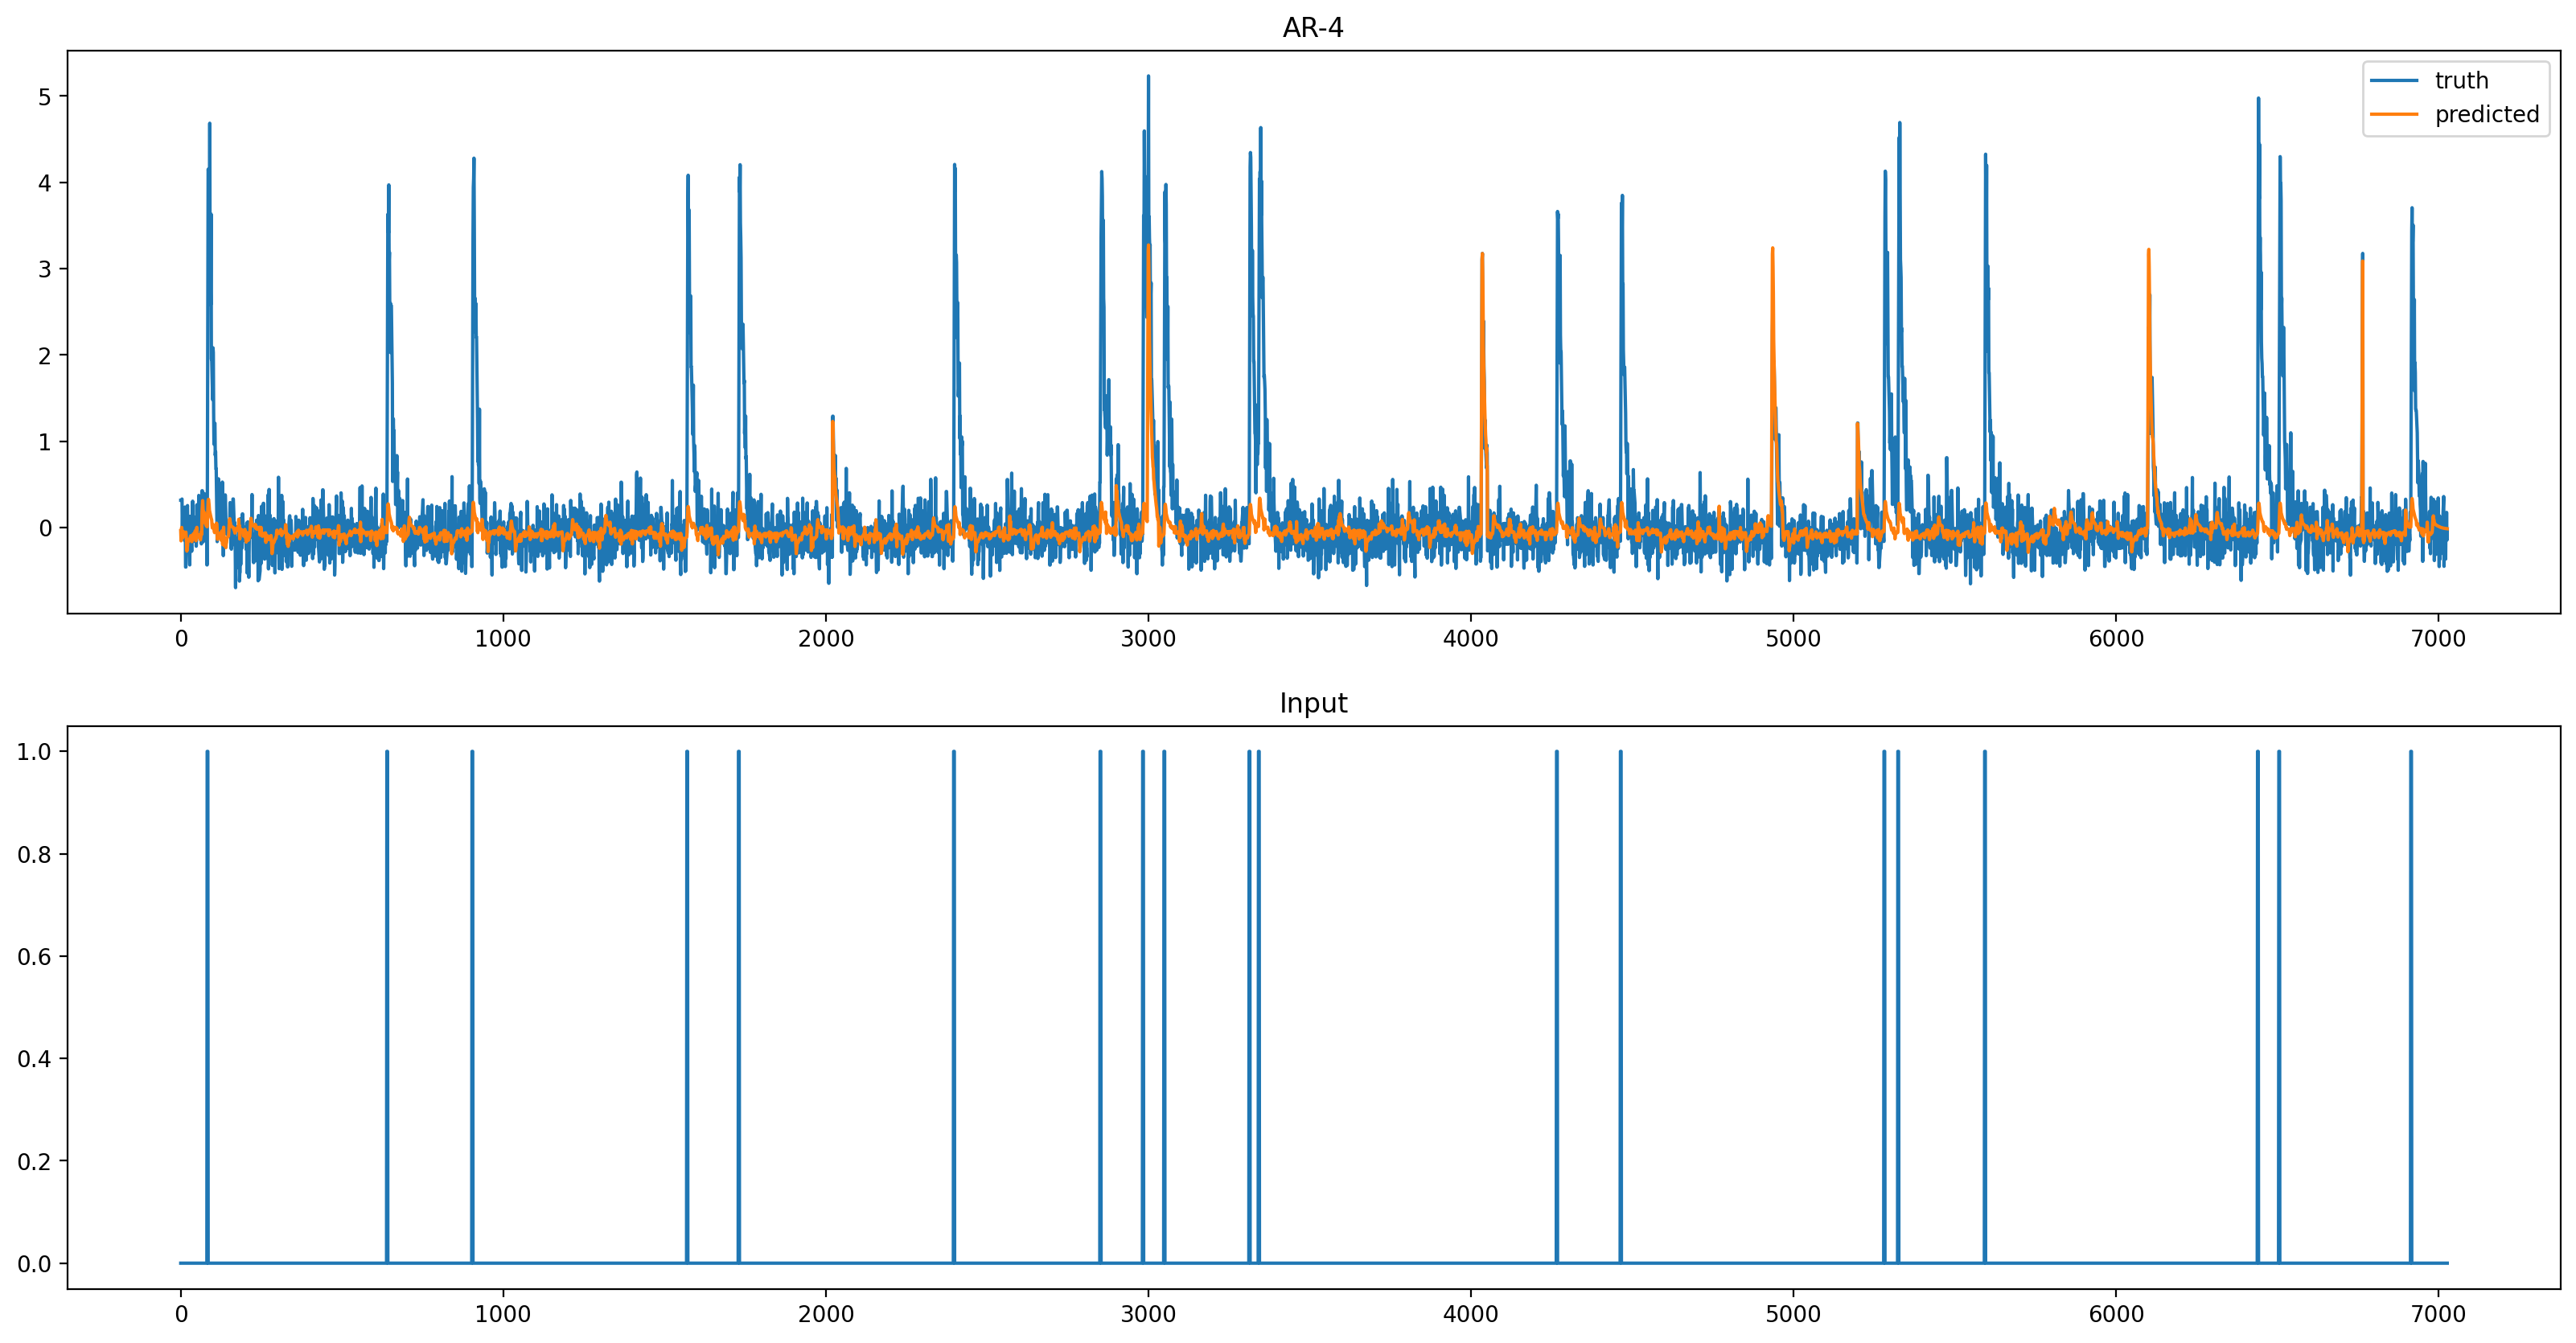

In [33]:
# linear model
neuron = removed_neurons[3]
length = 10000

output_pred = []
output_true = []
input_true = []
segment_marker = []

for i in range(np.min([len(x_true),length])):
    output_pred.extend(x_pred[i][:,neuron])
    #output_pred.append(np.nan)
    output_true.extend(x_true[i][:,neuron])
    #output_true.append(np.nan)
    input_true.extend(u_true[i][:,neuron])
    #input_true.append(np.nan)
    segment_marker.extend(np.nan*np.zeros(len(x_pred[i][:,neuron])-1))
    segment_marker.extend([0.25,0])
    
plt.figure(figsize=(20,10))
plt.subplot(2,1,1)
plt.plot(output_true,label='truth')
plt.plot(output_pred,label='predicted')
#plt.plot(segment_marker)
plt.title('AR-4')
plt.legend()

plt.subplot(2,1,2)
plt.plot(input_true,label='input')
plt.title('Input')

# Evaluate Fit

In [108]:
tpr = []
fpr = []
thresholds = np.linspace(-2,5,15)

for thresholds_idx in range(len(thresholds)):
    tp_total = 0
    fp_total = 0
    p_total = 0
    n_total = 0

    for neuron in range(u_session.shape[1]):
        output_pred = []
        output_true = []
        for i in range(len(x_true)):
            output_pred.extend(x_pred[i][:,neuron])
            output_true.extend(x_true[i][:,neuron])
        output_pred = np.array(output_pred)
        output_true = np.array(output_true)
    
        mean_threshold = np.median(output_true)
        lower_tail_idx = (output_true < mean_threshold)
        lower_tail_data = output_true[lower_tail_idx]
        lower_tail_std = np.std(lower_tail_data)
        true_spike_threshold = mean_threshold + 6*lower_tail_std
        detect_spike_threshold = mean_threshold + thresholds[thresholds_idx]*lower_tail_std

        predicted_spikes = (output_pred > detect_spike_threshold)
        true_spikes = (output_true > true_spike_threshold)
        tp_total += np.sum(np.logical_and(predicted_spikes,true_spikes))
        fp_total += np.sum(np.logical_and(predicted_spikes,~true_spikes))
        p_total += np.sum(true_spikes)
        n_total += np.sum(~true_spikes)

    tpr.append(tp_total / p_total)
    fpr.append(fp_total / n_total)

In [87]:
linear_fpr = fpr.copy()
linear_tpr = tpr.copy()

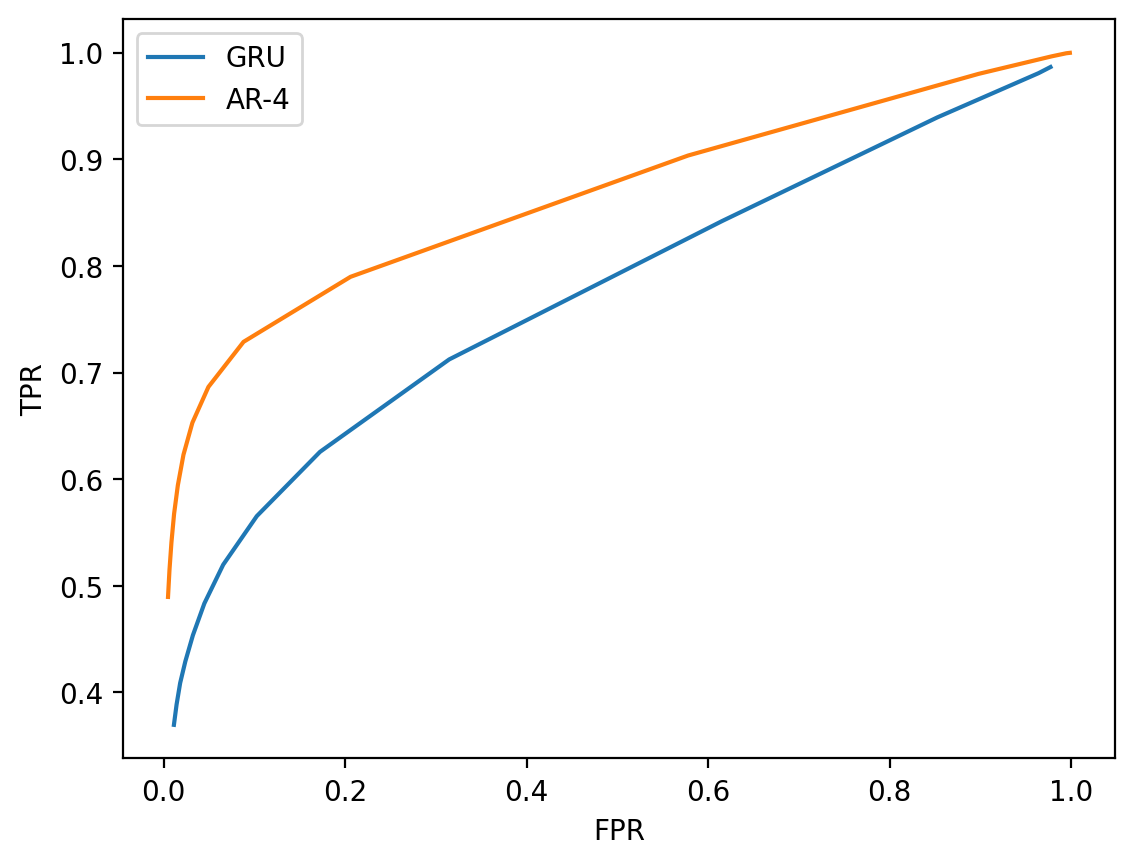

In [109]:
# deep model v.s. linear model
plt.plot(fpr,tpr,label='GRU')
plt.plot(linear_fpr,linear_tpr,label='AR-4')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
#plt.xlim([-0.1,0.2])
#plt.ylim([-0.1,1.1])

In [110]:
tpr_noninput = []
fpr_noninput = []
thresholds = np.linspace(-2,5,15)

for thresholds_idx in range(len(thresholds)):
    tp_total = 0
    fp_total = 0
    p_total = 0
    n_total = 0

    for neuron in range(u_session.shape[1]):
        output_pred = []
        output_true = []
        for i in range(len(x_true)):
            if np.sum(u_true[i][:,neuron]) == 0:
                output_pred.extend(x_pred[i][:,neuron])
                output_true.extend(x_true[i][:,neuron])
        output_pred = np.array(output_pred)
        output_true = np.array(output_true)
    
        mean_threshold = np.median(output_true)
        lower_tail_idx = (output_true < mean_threshold)
        lower_tail_data = output_true[lower_tail_idx]
        lower_tail_std = np.std(lower_tail_data)
        true_spike_threshold = mean_threshold + 6*lower_tail_std
        detect_spike_threshold = mean_threshold + thresholds[thresholds_idx]*lower_tail_std

        predicted_spikes = (output_pred > detect_spike_threshold)
        true_spikes = (output_true > true_spike_threshold)
        tp_total += np.sum(np.logical_and(predicted_spikes,true_spikes))
        fp_total += np.sum(np.logical_and(predicted_spikes,~true_spikes))
        p_total += np.sum(true_spikes)
        n_total += np.sum(~true_spikes)

    tpr_noninput.append(tp_total / p_total)
    fpr_noninput.append(fp_total / n_total)

In [89]:
linear_fpr_noninput = fpr_noninput.copy()
linear_tpr_noninput = tpr_noninput.copy()

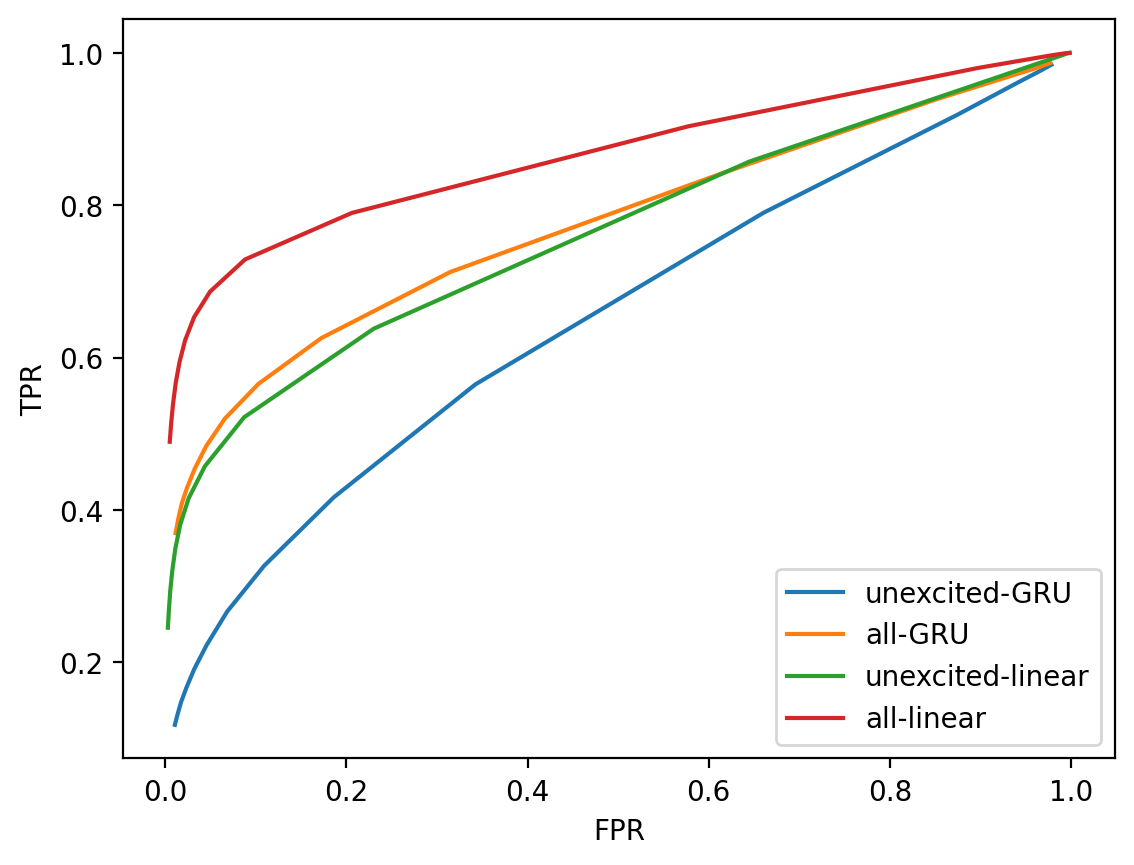

In [111]:
# deep model v.s. linear model
plt.plot(fpr_noninput,tpr_noninput,label='unexcited-GRU')
plt.plot(fpr,tpr,label='all-GRU')
plt.plot(linear_fpr_noninput,linear_tpr_noninput,label='unexcited-linear')
plt.plot(linear_fpr,linear_tpr,label='all-linear')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
#plt.xlim([-0.1,0.2])
#plt.ylim([-0.1,1.1])